In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import time
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit, cross_val_score
from sklearn.pipeline import make_pipeline
#from imblearn.pipeline import make_pipeline as make_pipeline_imb
##from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import NearMiss
#from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, precision_recall_curve

In [2]:
train_data = pd.read_csv('training.csv', sep=',')
test_data = pd.read_csv('test.csv', sep=',')

In [3]:
pd.DataFrame({'Time' : train_data['TransactionStartTime']}).to_csv('train_trans_time.csv', index=False)
pd.DataFrame({'Time' : test_data['TransactionStartTime']}).to_csv('test_trans_time.csv', index=False)

In [3]:
train_id = train_data['TransactionId'].copy() # Use .copy() to avoid SettingWithCopyWarning later
test_id = test_data['TransactionId'].copy()
label = train_data['FraudResult'].copy()

In [4]:
n_train = train_data.shape[0]
print(f"Number of training samples: {n_train}")

Number of training samples: 95662


In [137]:
# Define hour bins (convert strings to integers for comparison)
most_freq_hours = [17, 16, 9, 13, 18]
least_freq_hours = [0, 1, 23, 2, 3, 22]

# Apply transformations similar to the R mutate block
# Use intermediate variables for clarity or chain .assign()

# 1. Extract digits and convert ID columns to numeric (handle potential errors)
id_cols = ['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'ProviderId', 'ProductId', 'ChannelId']
for col in id_cols:
    # Extract digits using regex; fill non-matches with NaN, then convert to a nullable integer type
    train_data[col] = train_data[col].str.extract(r'(\d+)', expand=False).astype(float).astype('Int64') # Use float first for NaN, then Int64
    test_data[col] = test_data[col].str.extract(r'(\d+)', expand=False).astype(float).astype('Int64') # Use float first for NaN, then Int64

# 2. Convert TransactionStartTime to datetime


In [ ]:
train_data['TransactionStartTime'] = pd.to_datetime(train_data['TransactionStartTime'])
test_data['TransactionStartTime'] = pd.to_datetime(test_data['TransactionStartTime'])

In [138]:
cols_to_drop = ['CurrencyCode', 'CountryCode']

In [7]:
train_data['hour'] = train_data['TransactionStartTime'].dt.hour
train_data['week_day'] = train_data['TransactionStartTime'].dt.dayofweek

test_data['hour'] = test_data['TransactionStartTime'].dt.hour
test_data['week_day'] = test_data['TransactionStartTime'].dt.dayofweek

In [139]:
conditions_train = [
    train_data['hour'].isin(most_freq_hours),
    train_data['hour'].isin(least_freq_hours)
]
conditions_test = [
    test_data['hour'].isin(most_freq_hours),
    test_data['hour'].isin(least_freq_hours)
]
choices = [1, 2]
train_data['hour_test_bin'] = np.select(conditions_train, choices, default=3)
test_data['hour_test_bin'] = np.select(conditions_test, choices, default=3)



In [140]:
cols_to_drop.extend(['TransactionStartTime'])

In [141]:
print("Creating count-based features...")
train_data['Value_cnt'] = train_data.groupby('Value')['Value'].transform('count')
train_data['Prov_id_hr_prodid_cnt'] = train_data.groupby(['ProviderId', 'hour', 'ProductId'])['ProviderId'].transform('count')
train_data['Prov_id_hr_cha_cnt'] = train_data.groupby(['ProviderId', 'hour', 'ChannelId'])['ProviderId'].transform('count')
train_data['provid_chaid_hr_test_bin_cnt'] = train_data.groupby(['ProviderId', 'ChannelId', 'hour_test_bin'])['ProviderId'].transform('count')
train_data['prodcat_provid_cnt'] = train_data.groupby(['ProductCategory', 'ProductId'])['ProductCategory'].transform('count') # R code uses ProviderId here, assuming typo, using ProductCategory
train_data['prodcat_prodid_hr_test_bin_cnt'] = train_data.groupby(['ProductCategory', 'ProductId', 'hour_test_bin'])['ProductCategory'].transform('count')
train_data['provid_wday_hr_test_bin_cnt'] = train_data.groupby(['ProviderId', 'week_day', 'hour_test_bin'])['ProviderId'].transform('count')
train_data['prodid_wday_hr_test_bin_cnt'] = train_data.groupby(['ProductId', 'week_day', 'hour_test_bin'])['ProductId'].transform('count')

Creating count-based features...


In [142]:
print("Creating count-based features...")
test_data['Value_cnt'] = test_data.groupby('Value')['Value'].transform('count')
test_data['Prov_id_hr_prodid_cnt'] = test_data.groupby(['ProviderId', 'hour', 'ProductId'])['ProviderId'].transform('count')
test_data['Prov_id_hr_cha_cnt'] = test_data.groupby(['ProviderId', 'hour', 'ChannelId'])['ProviderId'].transform('count')
test_data['provid_chaid_hr_test_bin_cnt'] = test_data.groupby(['ProviderId', 'ChannelId', 'hour_test_bin'])['ProviderId'].transform('count')
test_data['prodcat_provid_cnt'] = test_data.groupby(['ProductCategory', 'ProductId'])['ProductCategory'].transform('count') # R code uses ProviderId here, assuming typo, using ProductCategory
test_data['prodcat_prodid_hr_test_bin_cnt'] = test_data.groupby(['ProductCategory', 'ProductId', 'hour_test_bin'])['ProductCategory'].transform('count')
test_data['provid_wday_hr_test_bin_cnt'] = test_data.groupby(['ProviderId', 'week_day', 'hour_test_bin'])['ProviderId'].transform('count')
test_data['prodid_wday_hr_test_bin_cnt'] = test_data.groupby(['ProductId', 'week_day', 'hour_test_bin'])['ProductId'].transform('count')

Creating count-based features...


In [143]:
cols_to_drop.append('hour_test_bin')

In [144]:
cols_to_drop

['CurrencyCode', 'CountryCode', 'TransactionStartTime', 'hour_test_bin']

In [145]:
train_data.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'Amount', 'Value',
       'TransactionStartTime', 'PricingStrategy', 'FraudResult', 'hour',
       'week_day', 'prophet_trend', 'prophet_daily', 'prophet_weekly',
       'time_since_last_tx', 'hmm_state', 'hmm_prob_state_0',
       'hmm_prob_state_1', 'hmm_prob_state_2', 'Amount_state',
       'Amount_state_previous', 'markov_transition_prob', 'hour_test_bin',
       'Value_cnt', 'Prov_id_hr_prodid_cnt', 'Prov_id_hr_cha_cnt',
       'provid_chaid_hr_test_bin_cnt', 'prodcat_provid_cnt',
       'prodcat_prodid_hr_test_bin_cnt', 'provid_wday_hr_test_bin_cnt',
       'prodid_wday_hr_test_bin_cnt'],
      dtype='object')

In [146]:
train_data.drop([
    'TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'CurrencyCode',
    'CountryCode', 'ProductId'
], axis=1, inplace=True)

testTransId = test_data['TransactionId']
test_data.drop([
    'TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'CurrencyCode',
    'CountryCode', 'ProductId'], axis=1, inplace=True)

In [262]:
def amount_value(data):
    amount = data[0]
    value = data[1]
    
    if np.abs(amount) != value:
        return value - np.abs(amount)
    else:
        return 0
    
train_data['ExtraCharges'] = train_data[['Amount', 'Value']].apply(amount_value, axis=1)
test_data['ExtraCharges'] = test_data[['Amount', 'Value']].apply(amount_value, axis=1)

C:\Users\HP PRO\AppData\Local\Temp\ipykernel_5948\321900281.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  amount = data[0]
C:\Users\HP PRO\AppData\Local\Temp\ipykernel_5948\321900281.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value = data[1]
C:\Users\HP PRO\AppData\Local\Temp\ipykernel_5948\321900281.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  amount = data[0]
C:\Users\HP PRO\AppData\Local\Temp\ipykernel_5948\

In [6]:
newColumns = [
    'ProviderId', 'ProductCategory', 'ChannelId', 'Amount', 'ExtraCharges', 'Value',
    'TransactionStartTime', 'PricingStrategy', 'FraudResult'
]

train_data = train_data.reindex(columns=newColumns)
test_data = test_data.reindex(columns=newColumns[:-1])

In [7]:
train_data.drop('Value', axis=1, inplace=True)
test_data.drop('Value', axis=1, inplace=True)

In [8]:
def get_year(trans_time):
    yr = trans_time.split('T')[0].split('-')[0]
    return yr

train_data['Year'] = train_data['TransactionStartTime'].map(get_year)
test_data['Year'] = test_data['TransactionStartTime'].map(get_year)

In [9]:
def get_month(trans_time):
    month = trans_time.split('T')[0].split('-')[1]
    
    if month == '11':
        return 'November'
    elif month == '12':
        return 'December'
    elif month == '01':
        return 'January'
    elif month == '02':
        return 'February'
    elif month == '03':
        return 'March'
    
train_data['Month'] = train_data['TransactionStartTime'].map(get_month)
test_data['Month'] = test_data['TransactionStartTime'].map(get_month)

In [10]:
from datetime import datetime
import calendar


def get_weekday(trans_time):
    yr = trans_time.split('T')[0].split('-')[0]
    month = trans_time.split('T')[0].split('-')[1]
    day = trans_time.split('T')[0].split('-')[2]
    
    date = datetime(year=int(yr), month=int(month), day=int(day))
    return calendar.day_name[date.weekday()]

train_data['Weekday'] = train_data['TransactionStartTime'].map(get_weekday)
test_data['Weekday'] = test_data['TransactionStartTime'].map(get_weekday)

In [11]:
def get_hour(trans_time):
    hour = trans_time.split('T')[1].split(':')[0]
    time_interval = ''
    
    if (hour=='00') | (hour=='01') | (hour=='02') | (hour=='03') | (hour=='04') | (hour=='05'):
        time_interval = 'early morning'
    elif (hour=='06') | (hour=='07') | (hour=='08') | (hour=='09') | (hour=='10') | (hour=='11'):
        time_interval = 'morning'
    elif (hour=='12') | (hour=='13') | (hour=='14') | (hour=='15'):
        time_interval = 'afternoon'
    elif (hour=='16') | (hour=='17') | (hour=='18') | (hour=='19'):
        time_interval = 'evening'
    elif (hour=='20') | (hour=='21') | (hour=='22') | (hour=='23'):
        time_interval = 'night'
        
    
    return time_interval


train_data['Time Interval'] = train_data['TransactionStartTime'].map(get_hour)
test_data['Time Interval'] = test_data['TransactionStartTime'].map(get_hour)

In [12]:
train_data['Time Interval'].value_counts()


Time Interval
morning          34342
evening          26061
afternoon        21950
early morning     7837
night             5472
Name: count, dtype: int64

In [147]:
train_data.drop('TransactionStartTime', axis=1, inplace=True)
test_data.drop('TransactionStartTime', axis=1, inplace=True)

In [ ]:
fraudResult = train_data['FraudResult']

train_amount = train_data['Amount']
train_charges = train_data['ExtraCharges']

test_amount = test_data['Amount']
test_charges = test_data['ExtraCharges']


train_data = train_data.drop(['Amount', 'FraudResult', 'ExtraCharges'], axis=1)
test_data = test_data.drop(['Amount', 'ExtraCharges'], axis=1)



In [15]:
combined = pd.concat([train_data, test_data], axis=0)#.reset_index(drop=True)


In [16]:
combined = pd.get_dummies(combined, columns=combined.columns[:-1], drop_first=True)

train_data = combined[combined['label']==1]
test_data = combined[combined['label']==0]

In [17]:

train_data.drop('label', axis=1, inplace=True)
test_data.drop('label', axis=1, inplace=True)

C:\Users\HP PRO\AppData\Local\Temp\ipykernel_5948\1986275239.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop('label', axis=1, inplace=True)
C:\Users\HP PRO\AppData\Local\Temp\ipykernel_5948\1986275239.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop('label', axis=1, inplace=True)


In [19]:
train_data = pd.concat([train_data, train_amount, train_charges, fraudResult], axis=1)
test_data = pd.concat([test_data, test_amount, test_charges,], axis=1)

In [16]:
train_data['Amount_type'] = np.where(train_data['Amount'] > 0, "Debit", "Credit")
train_data['Amount_type'] = train_data['Amount_type'].astype('category').cat.codes

In [17]:
test_data['Amount_type'] = np.where(test_data['Amount'] > 0, "Debit", "Credit")
test_data['Amount_type'] = test_data['Amount_type'].astype('category').cat.codes

In [245]:
train_data['label'] = 1
test_data['label'] = 0

In [246]:
combined = pd.concat([train_data, test_data], axis=0)#.reset_index(drop=True)
combined = pd.get_dummies(combined, columns=combined.columns[:-1], drop_first=True)

train_data = combined[combined['label']==1]
test_data = combined[combined['label']==0]

In [18]:
train_data.columns

Index(['ProviderId', 'ProductCategory', 'ChannelId', 'Amount', 'Value',
       'TransactionStartTime', 'PricingStrategy', 'FraudResult', 'hour',
       'week_day', 'hour_test_bin', 'Value_cnt', 'Prov_id_hr_prodid_cnt',
       'Prov_id_hr_cha_cnt', 'provid_chaid_hr_test_bin_cnt',
       'prodcat_provid_cnt', 'prodcat_prodid_hr_test_bin_cnt',
       'provid_wday_hr_test_bin_cnt', 'prodid_wday_hr_test_bin_cnt',
       'Amount_type'],
      dtype='object')

In [19]:
cols_to_drop

['CurrencyCode', 'CountryCode', 'TransactionStartTime', 'hour_test_bin']

In [149]:
cols_to_drop.extend(['TransactionId', 'BatchId', 'SubscriptionId', 'CustomerId']) # Match R drops
# Also drop original 'Amount' as Amount_type and Value_Amount_diff were derived
cols_to_drop.append('Amount')

In [150]:
cols_to_drop = [col for col in cols_to_drop if col in train_data.columns]
print(f"Dropping columns: {cols_to_drop}")


Dropping columns: ['hour_test_bin', 'Amount']


In [151]:
train_data = train_data.drop(columns=cols_to_drop)
test_data = test_data.drop(columns=cols_to_drop)


In [24]:
train_data['ProductCategory'] = train_data['ProductCategory'].astype('category').cat.codes
test_data['ProductCategory'] = test_data['ProductCategory'].astype('category').cat.codes

In [25]:
train_data['PricingStrategy']

0        2
1        2
2        2
3        2
4        2
        ..
95657    2
95658    2
95659    2
95660    2
95661    2
Name: PricingStrategy, Length: 95662, dtype: int64

In [152]:
train_data.columns

Index(['ProviderId', 'ProductCategory', 'ChannelId', 'Value',
       'PricingStrategy', 'FraudResult', 'hour', 'week_day', 'prophet_trend',
       'prophet_daily', 'prophet_weekly', 'time_since_last_tx', 'hmm_state',
       'hmm_prob_state_0', 'hmm_prob_state_1', 'hmm_prob_state_2',
       'Amount_state', 'Amount_state_previous', 'markov_transition_prob',
       'Value_cnt', 'Prov_id_hr_prodid_cnt', 'Prov_id_hr_cha_cnt',
       'provid_chaid_hr_test_bin_cnt', 'prodcat_provid_cnt',
       'prodcat_prodid_hr_test_bin_cnt', 'provid_wday_hr_test_bin_cnt',
       'prodid_wday_hr_test_bin_cnt'],
      dtype='object')

In [155]:
cols_to_drop = ['ProductCategory','ChannelId']


In [156]:
train_data = train_data.drop(columns=cols_to_drop)
test_data = test_data.drop(columns=cols_to_drop)


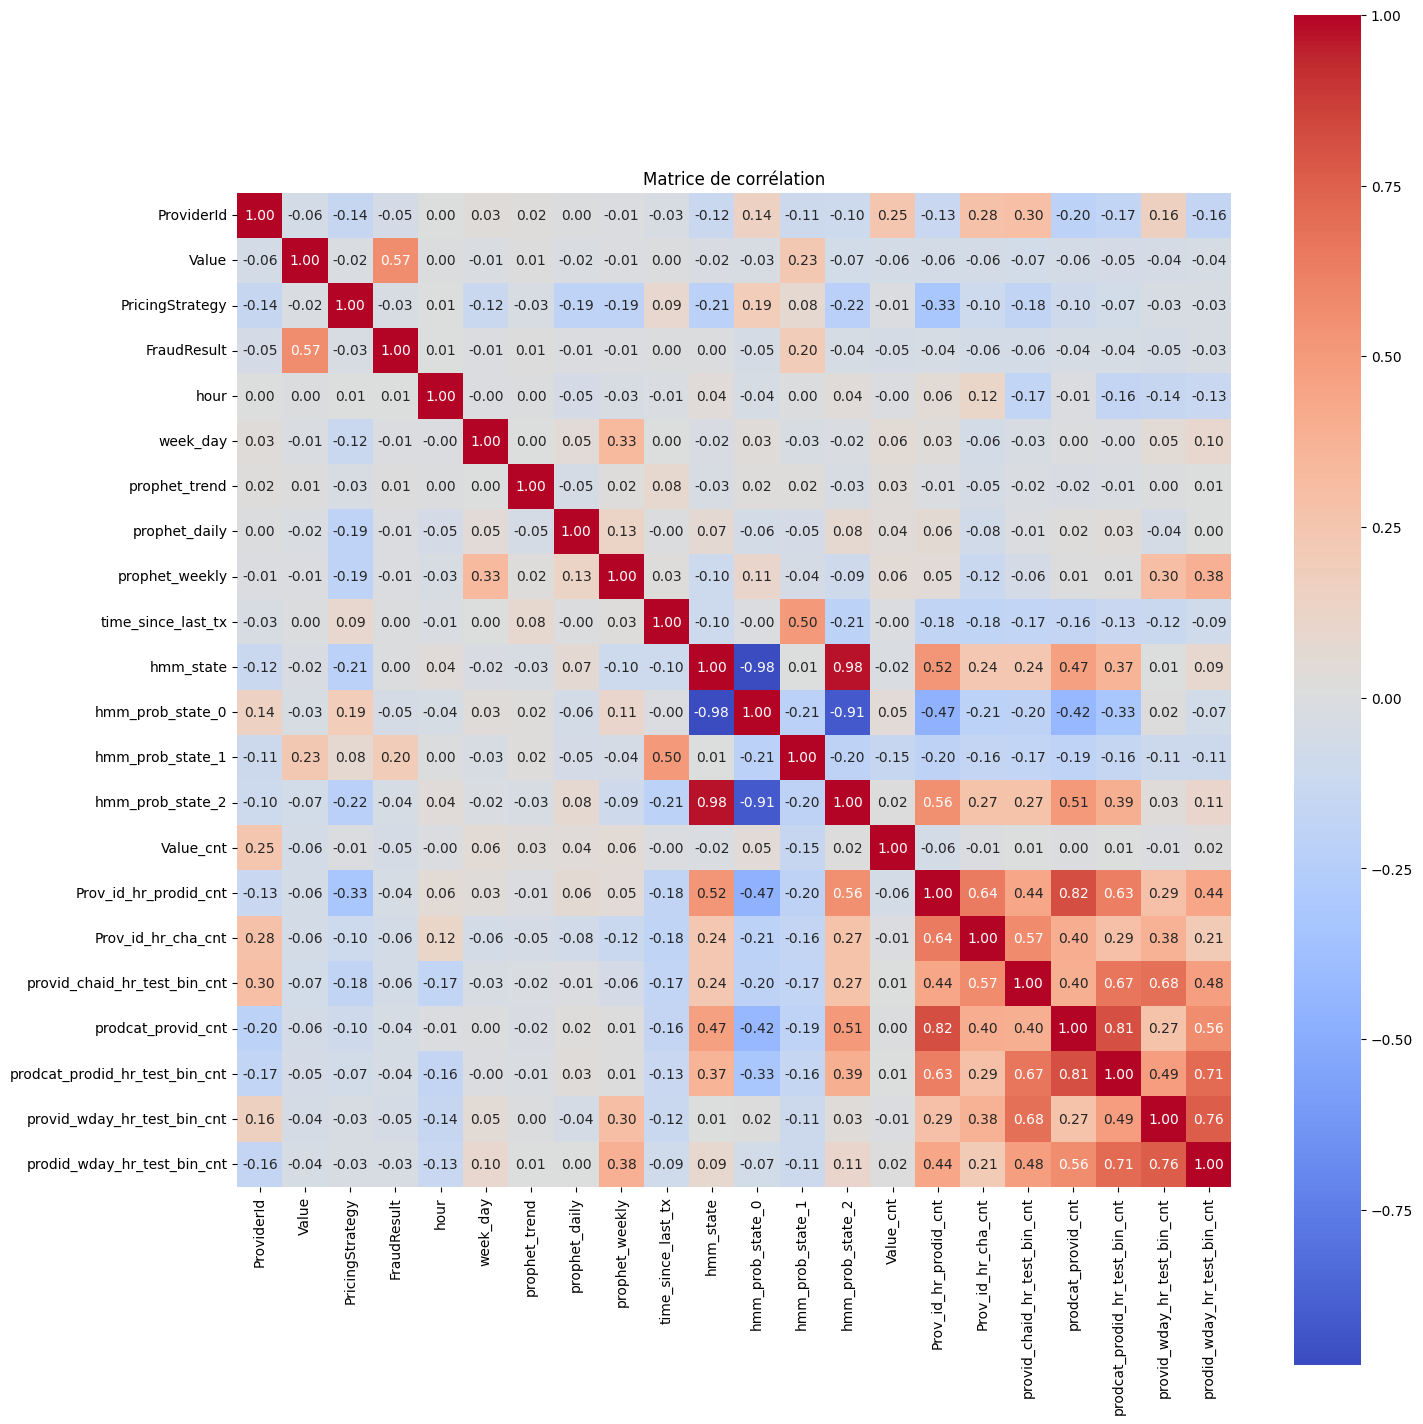

In [292]:
corr_matrix = train_data.corr()

# 3. Affichage avec une heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Matrice de corrélation')
plt.tight_layout()
plt.show()


In [202]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures


In [203]:
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Encodage des catégories
scaler = StandardScaler()  # Mise à l'échelle des variables numériques
poly = PolynomialFeatures(degree=2, include_bias=False)

In [205]:
train_data.columns

Index(['ProviderId', 'Value', 'PricingStrategy', 'FraudResult', 'hour',
       'week_day', 'prophet_trend', 'prophet_daily', 'prophet_weekly',
       'time_since_last_tx', 'hmm_state', 'hmm_prob_state_0',
       'hmm_prob_state_1', 'hmm_prob_state_2', 'Amount_state',
       'Amount_state_previous', 'markov_transition_prob', 'Value_cnt',
       'Prov_id_hr_prodid_cnt', 'Prov_id_hr_cha_cnt',
       'provid_chaid_hr_test_bin_cnt', 'prodcat_provid_cnt',
       'prodcat_prodid_hr_test_bin_cnt', 'provid_wday_hr_test_bin_cnt',
       'prodid_wday_hr_test_bin_cnt'],
      dtype='object')

In [208]:
train_data.head()

,ProviderId,Value,PricingStrategy,FraudResult,hour,week_day,prophet_trend,prophet_daily,prophet_weekly,time_since_last_tx,...,Amount_state_previous,markov_transition_prob,Value_cnt,Prov_id_hr_prodid_cnt,Prov_id_hr_cha_cnt,provid_chaid_hr_test_bin_cnt,prodcat_provid_cnt,prodcat_prodid_hr_test_bin_cnt,provid_wday_hr_test_bin_cnt,prodid_wday_hr_test_bin_cnt
5184,4,10000,4,0,16,2,823800.499543,1.371243e+06,1.062313e+06,132.0,...,-1,0.035008,7944,423,3271,12370,15384,4867,1324,387
5178,4,10000,4,0,16,2,823800.499543,1.371243e+06,1.062313e+06,132.0,...,-1,0.035008,7944,586,3271,12370,24344,8112,1324,833
1122,5,10000,2,0,7,4,198427.381698,1.371243e+06,7.322976e+06,132.0,...,-1,0.667557,7944,472,878,9211,11964,7652,3040,2628
1148,6,10000,2,0,8,4,198427.381698,1.371243e+06,7.322976e+06,1385.0,...,2,0.422576,7944,710,2152,21703,15384,10141,6061,3666
1149,4,200,2,0,8,4,198427.381698,1.371243e+06,7.322976e+06,12.0,...,2,0.448338,551,1901,1930,24027,32635,21008,6804,6651


In [220]:
train_data['prodid_wday_hr_test_bin_cnt'].value_counts()

prodid_wday_hr_test_bin_cnt
6651    6651
3666    3666
3483    3483
3434    3434
3281    3281
        ... 
25        25
24        24
23        23
3         21
20        20
Name: count, Length: 165, dtype: Int64

In [221]:
numerical_vars=[ 'Value', 'hour',
        'prophet_trend', 'prophet_daily', 'prophet_weekly',
       'time_since_last_tx',  'hmm_prob_state_0',
       'hmm_prob_state_1', 'hmm_prob_state_2', 
        'markov_transition_prob', 'Value_cnt',
       'Prov_id_hr_prodid_cnt', 'Prov_id_hr_cha_cnt',
       'provid_chaid_hr_test_bin_cnt', 'prodcat_provid_cnt',
       'prodcat_prodid_hr_test_bin_cnt', 'provid_wday_hr_test_bin_cnt',
       'prodid_wday_hr_test_bin_cnt']
categorical_vars=['ProviderId','PricingStrategy','hmm_state','Amount_state','Amount_state_previous','week_day']

In [272]:
#temp
numerical_vars=[ 'Value', 'hour',
        'prophet_trend', 'prophet_daily', 'prophet_weekly',
       'time_since_last_tx',  'hmm_prob_state_0',
       'hmm_prob_state_1', 'hmm_prob_state_2', 
         'Value_cnt',
       'Prov_id_hr_prodid_cnt', 'Prov_id_hr_cha_cnt',
       'provid_chaid_hr_test_bin_cnt', 'prodcat_provid_cnt',
       'prodcat_prodid_hr_test_bin_cnt', 'provid_wday_hr_test_bin_cnt',
       'prodid_wday_hr_test_bin_cnt']
categorical_vars=['ProviderId','PricingStrategy','hmm_state','week_day']

In [293]:
X_numerical_new = scaler.fit_transform(X[numerical_vars])  # Normalisation
X_numerical_poly_new = poly.fit_transform(X_numerical_new)
X_categorical = encoder.fit_transform(X[categorical_vars])
X_new = np.hstack([X_categorical, X_numerical_poly_new])

In [273]:
test_data_numerical_new = scaler.fit_transform(test_data[numerical_vars])  # Normalisation
test_data_numerical_poly_new = poly.fit_transform(test_data_numerical_new)
test_data_categorical = encoder.fit_transform(test_data[categorical_vars])
test_data_new = np.hstack([test_data_categorical, test_data_numerical_poly_new])

In [267]:
test_data_new = pd.DataFrame(test_data_new)

KeyError: "['Amount_state', 'Amount_state_previous', 'markov_transition_prob'] not found in axis"

In [270]:
pd.DataFrame(test_data_new).head()

,0,1,2,3,4,5,6,7,8,9,...,200,201,202,203,204,205,206,207,208,209
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,3.893114,3.273711,1.459441,1.924042,2.752857,1.227241,1.617923,0.547112,0.721280,0.950894
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.103528,0.192527,0.154927,-0.086139,0.358036,0.288112,-0.160189,0.231844,-0.128905,0.071671
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.281490,0.064918,0.110391,0.611331,0.003289,0.005592,0.030969,0.009509,0.052662,0.291634
3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.005573,0.026907,-0.017545,-0.024623,0.129914,-0.084710,-0.118885,0.055235,0.077518,0.108792
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.005573,0.026907,-0.017545,-0.024623,0.129914,-0.084710,-0.118885,0.055235,0.077518,0.108792


In [294]:
X, y = train_data.drop('FraudResult', axis=1), train_data['FraudResult']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)

In [287]:

X_train, X_test, y_train, y_test = train_test_split(
    train_processed, target, stratify=y, test_size=0.25, random_state=42
)

In [226]:
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, stratify=y, test_size=0.25, random_state=42
)

In [288]:
Counter(y_train)


Counter({0: 71601, 1: 145})

In [161]:
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True )


In [162]:
import xgboost as xgb
from xgboost import plot_importance

In [295]:
model = xgb.XGBClassifier(
    max_depth=4, min_child_weight=1, gamma = 0, subsample=0.8, colsample_bytree=0.8,
    scale_pos_weight = len(y_train[y_train==0])/len(y_train[y_train==1]), nthread=-1,enable_categorical=True
)

model.fit(X_train, y_train)

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

print('Train Score: {:4f}'.format(f1_score(y_train, train_predictions)))
print('Test Score: {:4f}'.format(f1_score(y_test, test_predictions)))

Train Score: 0.960265
Test Score: 0.781818


In [296]:
val = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1, verbose=0).mean()


print('Model CV Score: {}'.format(val))

Model CV Score: 0.7510665601250286


In [49]:
scale_pos_weight = len(y_train[y_train]==0)/len(y_train[y_train==1])

In [40]:
params_1 = {
    'max_depth' : [3, 4, 5, 7],
    'min_child_weight' : list(range(1, 6, 2))
}

grid = GridSearchCV(
    xgb.XGBClassifier(
    max_depth=4, min_child_weight=1, gamma = 0, subsample=0.8, colsample_bytree=0.8,
    scale_pos_weight = len(y_train[y_train]==0)/len(y_train[y_train==1]), nthread=-1
), params_1, scoring='f1', n_jobs=-1, refit=True, verbose=0, cv=cv
)

grid.fit(X_train, y_train)

grid.cv_results_

{'mean_fit_time': array([2.55806408, 2.68445501, 2.64840374, 2.73159552, 3.11414714,
        2.88440742, 3.07921524, 2.92421174, 2.82018013, 3.08189697,
        3.01092715, 3.06621819]),
 'std_fit_time': array([0.13233374, 0.04811733, 0.08445753, 0.03166878, 0.08269971,
        0.18472982, 0.2290062 , 0.15048512, 0.03743421, 0.05628186,
        0.09097332, 0.09545608]),
 'mean_score_time': array([0.11649656, 0.13433366, 0.11184778, 0.12196188, 0.16173005,
        0.1285965 , 0.14395881, 0.14375043, 0.12785549, 0.14549246,
        0.15076094, 0.11693101]),
 'std_score_time': array([0.02993505, 0.01992139, 0.0170749 , 0.02284419, 0.03603427,
        0.01044122, 0.02891121, 0.01616275, 0.01261046, 0.0228802 ,
        0.01049078, 0.01864375]),
 'param_max_depth': masked_array(data=[3, 3, 3, 4, 4, 4, 5, 5, 5, 7, 7, 7],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value=999999),
 'param_min_child_wei

In [30]:
grid.best_params_, grid.best_score_


({'max_depth': 7, 'min_child_weight': 1}, 0.5975971318734867)

In [297]:
dtrain = xgb.DMatrix(train_data.drop('FraudResult', axis=1), label=label)
dtest = xgb.DMatrix(test_data)

watchlist = [(dtrain, 'train')]

In [298]:
xgb_params = {
    'colsample_bytree': 0.5,
    'subsample': 0.5,
    'booster': 'gbtree',
    'max_depth': 3,
    'min_child_weight': 0, # Note: R default might differ slightly if not set
    'learning_rate': 0.03,
    # 'gamma': 0, # Uncomment if needed
    'nthread': -1, # Use all available threads
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'seed': 1235 # For reproducibility
}

# --- XGBoost Cross-Validation ---
print("Running XGBoost CV...")
nrounds_cv = 5000
early_stopping_rounds_cv = 100
nfold_cv = 5

xgb_cv = xgb.cv(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=nrounds_cv,
    nfold=nfold_cv,
    metrics={'auc'},
    early_stopping_rounds=early_stopping_rounds_cv,
    seed=1235,
    verbose_eval=50 # Print progress every 50 rounds
)

# Get the best number of rounds from CV
best_nrounds = xgb_cv.shape[0]
print(f"Best number of rounds found by CV: {best_nrounds}")
print(f"Best CV AUC: {xgb_cv['test-auc-mean'].iloc[-1]:.6f}")


Running XGBoost CV...
[0]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[50]	train-auc:0.55449+0.01687	test-auc:0.50742+0.01792
[100]	train-auc:0.71071+0.01047	test-auc:0.52753+0.01775
[150]	train-auc:0.77224+0.00989	test-auc:0.55504+0.03477
[200]	train-auc:0.82198+0.01003	test-auc:0.56189+0.02280
[250]	train-auc:0.85879+0.00942	test-auc:0.56713+0.01731
[300]	train-auc:0.88077+0.01065	test-auc:0.56178+0.01333
[349]	train-auc:0.89933+0.00641	test-auc:0.56287+0.01686
Best number of rounds found by CV: 250
Best CV AUC: 0.568792


In [299]:
print(f"Training final XGBoost model with {best_nrounds} rounds...")
final_xgb_model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=best_nrounds, # Use rounds found from CV
    evals=watchlist,
    verbose_eval=0 # Show progress during training if desired
)

# --- Prediction ---
print("Making predictions on the test set...")
pred_proba = final_xgb_model.predict(dtest)

# Apply threshold (same as R script)
threshold = 0.51
pred_binary = (pred_proba > threshold).astype(int)
print(f"Number of positive predictions (FraudResult=1): {np.sum(pred_binary)}")


Training final XGBoost model with 250 rounds...
Making predictions on the test set...
Number of positive predictions (FraudResult=1): 0


In [300]:
print("Creating submission DataFrame...")
submission = pd.DataFrame({'TransactionId': test_id, 'FraudResult': pred_binary})


Creating submission DataFrame...


In [301]:
submission['FraudResult'].value_counts()

FraudResult
0    45019
Name: count, dtype: int64

In [284]:


# --- Write submission file ---
output_file = "sub_python.csv"
print(f"Writing final submission file to {output_file}...")
submission.to_csv(output_file, index=False)

print("Script finished successfully!")

Writing final submission file to sub_python.csv...
Script finished successfully!


In [167]:
import lightgbm as lgb


In [302]:
model = lgb.LGBMClassifier(
    objective='binary', class_weight={0:1, 1:99.7979888}, num_leaves=31, max_depth=5, 
    min_child_samples=20, min_child_weight=0.001, subsample=0.8, 
    colsample_bytree=0.8, subsample_freq=5,verbose=-1
)

model.fit(X_train, y_train)

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

print('Train Score: {:4f}'.format(f1_score(y_train, train_predictions)))
print('Test Score: {:4f}'.format(f1_score(y_test, test_predictions)))

Train Score: 0.960265
Test Score: 0.851852


In [303]:
el = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1, verbose=0)
print(el)
el.mean()

[0.79069767 0.89411765 0.85       0.81818182 0.91566265]


0.8537319580523313

In [37]:
lgb_grid.best_params_, lgb_grid.best_score_


({'max_depth': 5, 'num_leaves': 25}, 0.7732754924881436)

In [39]:
lgb_grid2.best_params_, lgb_grid2.best_score_


({'max_depth': 6, 'min_child_samples': 10}, 0.7977855054302422)

In [41]:
lgb_grid3.best_params_, lgb_grid3.best_score_


({'min_child_samples': 15, 'min_child_weight': 0.001, 'min_split_gain': 0.2},
 0.7959826565341445)

In [44]:
lgb_grid4.best_params_, lgb_grid4.best_score_


({'min_child_samples': 10, 'min_child_weight': 0.15, 'min_split_gain': 0.0},
 0.7974237590684959)

In [45]:
lgb_params_9 = {
    
    'subsample' : np.arange(0.3, 0.6, 0.05),
    'colsample_bytree' : np.arange(0.705, 0.9, 0.05)
                               
                               }

lgb_grid9 = GridSearchCV(
    lgb.LGBMClassifier(
    objective='binary', class_weight={0:1, 1:99.7979888}, num_leaves=21, max_depth=7, 
    min_child_samples=13, min_child_weight=0.3, min_split_gain=0.16, subsample=0.8, 
    colsample_bytree=0.8, subsample_freq=5
), lgb_params_9, scoring='f1', n_jobs=-1, refit=True, verbose=0, cv=cv
)

lgb_grid9.fit(X_train, y_train)

lgb_grid9.cv_results_

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 135, number of negative: 66828
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 66963, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167778 -> initscore=-1.601455
[LightGBM] [Info] Start training from score -1.601455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

{'mean_fit_time': array([1.58153529, 1.67021646, 1.49485383, 1.52932844, 1.49919701,
        1.48139005, 1.19725938, 1.14922843, 1.23779702, 1.41229911,
        1.66159139, 1.62723684, 1.09853687, 1.51129818, 1.19226789,
        1.32211452, 1.37459927, 1.39274249, 1.17052484, 1.28869619,
        1.14456687, 1.25334029, 1.28651361, 0.99077926]),
 'std_fit_time': array([0.22454571, 0.26232348, 0.18961121, 0.176559  , 0.1312043 ,
        0.08702026, 0.14248786, 0.10051999, 0.0550263 , 0.15633866,
        0.13445986, 0.11867984, 0.03341357, 0.17978381, 0.05305773,
        0.06533583, 0.04975797, 0.1329969 , 0.06162874, 0.10038934,
        0.05081638, 0.11925375, 0.09000546, 0.12604704]),
 'mean_score_time': array([0.08040075, 0.09458938, 0.07860222, 0.09039907, 0.07300229,
        0.07600212, 0.07142901, 0.07280211, 0.06700115, 0.07764125,
        0.0843997 , 0.07139745, 0.0644012 , 0.07063169, 0.06076818,
        0.06820025, 0.06439843, 0.06240306, 0.06511278, 0.07060065,
        0.063881

In [46]:
lgb_grid9.best_params_, lgb_grid9.best_score_


({'colsample_bytree': 0.8550000000000001, 'subsample': 0.3},
 0.8020004373735716)

In [47]:
lgb_params_11 = {
    
    'subsample_freq' : list(range(0, 12))
                               
                               }

lgb_grid11 = GridSearchCV(
    lgb.LGBMClassifier(
    objective='binary', class_weight={0:1, 1:99.7979888}, num_leaves=21, max_depth=7, 
    min_child_samples=13, min_child_weight=0.3, min_split_gain=0.16, subsample=0.485, 
    colsample_bytree=0.81, subsample_freq=5
), lgb_params_11, scoring='f1', n_jobs=-1, refit=True, verbose=0, cv=cv
)

lgb_grid11.fit(X_train, y_train)

lgb_grid11.cv_results_

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 135, number of negative: 66828
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 66963, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167778 -> initscore=-1.601455
[LightGBM] [Info] Start training from score -1.601455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

{'mean_fit_time': array([1.18939734, 1.53389192, 1.4182445 , 1.41524262, 1.22190328,
        1.28950653, 1.29459729, 1.25371642, 1.18786073, 1.30779729,
        1.87027349, 2.31993637]),
 'std_fit_time': array([0.23079196, 0.06177632, 0.10967918, 0.05402917, 0.05379778,
        0.08325893, 0.06368517, 0.11877239, 0.07062137, 0.05384584,
        0.41668521, 0.04741771]),
 'mean_score_time': array([0.08020296, 0.06600242, 0.06260309, 0.06525941, 0.06040077,
        0.06240172, 0.06560249, 0.069205  , 0.06717176, 0.06680117,
        0.08460364, 0.08040051]),
 'std_score_time': array([0.0170813 , 0.00502142, 0.00272658, 0.00349487, 0.00524241,
        0.00326058, 0.00588454, 0.0204695 , 0.00908704, 0.00805848,
        0.01195048, 0.00671139]),
 'param_subsample_freq': masked_array(data=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value=999999),
 'params': [{'

In [48]:
lgb_grid11.best_params_, lgb_grid11.best_score_


({'subsample_freq': 1}, 0.8146156649427043)

In [44]:
import optuna

In [304]:
def objective(trial):
    """Optuna objective function for LightGBM Hyperparameter Optimization using F1-Score."""

    # --- Define Hyperparameter Search Space (same as before) ---
    params = {
        'objective': 'binary',
        # --- Change metric to 'f1' (or include it: ['auc', 'f1']) ---
        'metric': ['auc','f1'],
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'scale_pos_weight ': 496,
        'n_estimators': 1000,

        
        
        # --- Hyperparameters to Optimize (same ranges as before) ---
        
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 64),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 1.0, log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 0.5),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 10.0, log=True),
        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 200000, step=20000),

        'random_state': 42,
        'n_jobs': -1
    }

    # --- Train the Model with Early Stopping ---
    model = lgb.LGBMClassifier(**params)

    # Define callbacks: Early stopping and Optuna Pruning
    # --- Use 'f1' for the pruning metric ---
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'auc')
    early_stopping_callback = lgb.early_stopping(
        stopping_rounds=100,
        verbose=False
    )

    model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              # --- Use 'f1' for the early stopping evaluation metric ---
              eval_metric='auc',
              callbacks=[early_stopping_callback, pruning_callback]
             )

    # --- Evaluate the Model using F1 Score ---
    preds_proba = model.predict_proba(X_test)[:, 1]

    # --- Convert probabilities to binary predictions (standard 0.5 threshold) ---
    # Note: For maximizing F1, threshold tuning *after* finding best params might be needed.
    # Optuna optimizes the model parameters assuming this threshold for now.
    threshold = 0.5
    preds_binary = (preds_proba >= threshold).astype(int)

    # --- Calculate the F1 score ---
    score = f1_score(y_test, preds_binary)
    return score

    return score # Optuna will maximize this F1 score

In [305]:
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
)

# --- Run the Optimization ---
study.optimize(objective, n_trials=200, timeout=3600) # Adjust n_trials/timeout as needed

# --- Get the Best Results ---
print("\nOptimization Finished!")
print(f"Number of finished trials: {len(study.trials)}")
print(f"Best trial number: {study.best_trial.number}")
# --- Update print statement for F1 ---
print(f"Best score (F1): {study.best_value:.6f}")

print("\nBest hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# --- Optional: Train Final Model with Best Params ---
print("\nTraining final model with best parameters on full training data...")

best_params = study.best_params.copy()

[I 2025-04-07 23:47:20,947] A new study created in memory with name: no-name-7794229e-6508-455c-9702-79e52102c815
[I 2025-04-07 23:47:22,157] Trial 0 finished with value: 0.0 and parameters: {'learning_rate': 0.0013292918943162175, 'num_leaves': 62, 'max_depth': 10, 'min_child_samples': 62, 'min_child_weight': 0.0029380279387035343, 'min_split_gain': 0.07799726016810132, 'subsample': 0.4348501673009197, 'subsample_freq': 9, 'colsample_bytree': 0.7606690070459252, 'reg_alpha': 0.034702669886504146, 'reg_lambda': 1.3289448722869181e-05, 'subsample_for_bin': 200000}. Best is trial 0 with value: 0.0.
[I 2025-04-07 23:47:23,927] Trial 1 finished with value: 0.8484848484848485 and parameters: {'learning_rate': 0.03142880890840111, 'num_leaves': 21, 'max_depth': 5, 'min_child_samples': 22, 'min_child_weight': 0.008179499475211672, 'min_split_gain': 0.2623782158161189, 'subsample': 0.6591670111852694, 'subsample_freq': 3, 'colsample_bytree': 0.7671117368334277, 'reg_alpha': 4.98275235707645e-0


Optimization Finished!
Number of finished trials: 200
Best trial number: 67
Best score (F1): 0.937500

Best hyperparameters:
  learning_rate: 0.06349128749136984
  num_leaves: 31
  max_depth: 4
  min_child_samples: 41
  min_child_weight: 0.007282033457588821
  min_split_gain: 0.3016171982930749
  subsample: 0.8737831133532253
  subsample_freq: 5
  colsample_bytree: 0.8431200387448448
  reg_alpha: 0.5634751224708875
  reg_lambda: 4.238651725450287e-05
  subsample_for_bin: 20000

Training final model with best parameters on full training data...


In [172]:
best_params 

{'n_estimators': 10000,
 'learning_rate': 0.02863368542586162,
 'num_leaves': 11,
 'max_depth': 8,
 'min_child_samples': 20,
 'min_child_weight': 0.009173826786868072,
 'min_split_gain': 0.24855633086867834,
 'subsample': 0.7019033851279933,
 'subsample_freq': 3,
 'colsample_bytree': 0.6511666603266366,
 'reg_alpha': 5.618419057181935e-05,
 'reg_lambda': 0.0007565485281916981,
 'subsample_for_bin': 80000}

In [306]:
lgbm = lgb.LGBMClassifier(**best_params, scale_pos_weight = scale_pos_weight,
                          objective='binary',
        # --- Change metric to 'f1' (or include it: ['auc', 'f1']) ---
        metric=['auc','f1'],
        verbosity= -1,
        boosting_type='gbdt',
        n_estimators=1000,
        
        random_state=42
)

In [358]:
lgbm.fit(X, y)

LGBMClassifier(colsample_bytree=0.9890380290417461,
               learning_rate=0.03310761939630062, max_depth=8, metric='f1',
               min_child_samples=9, min_child_weight=0.851061903208252,
               min_split_gain=0.13368799858394026, n_estimators=3400,
               num_leaves=53, objective='binary', random_state=42,
               reg_alpha=0.007378252906848559, reg_lambda=0.0014210576056425783,
               scale_pos_weight=496, subsample=0.48277652230452966,
               subsample_for_bin=160000, subsample_freq=9, verbosity=-1)

In [307]:
lgbm.fit(X_train, y_train)


train_predictions = lgbm.predict(X_train)
test_predictions = lgbm.predict(X_test)

print('Train Score: {:4f}'.format(f1_score(y_train, train_predictions)))
print('Test Score: {:4f}'.format(f1_score(y_test, test_predictions)))

Train Score: 0.210914
Test Score: 0.225962


In [308]:
confusion_matrix(y_test, lgbm.predict(X_test))


array([[23547,   321],
       [    1,    47]], dtype=int64)

In [309]:
el = cross_val_score(lgbm, X, y, scoring='f1', cv=cv, n_jobs=-1, verbose=0)
print(el)
el.mean()

[0.21487603 0.02555481 0.01607143 0.22368421 0.17948718]


0.1319347319963425

In [310]:
y_proba_test = lgbm.predict_proba(X_test)[:, 1]

# Balayage simple de seuil [0, 1] par pas de 0.01
best_thresh = 0.2
best_f1 = 0

for thresh in np.linspace(0, 1, 101):
    preds_temp = (y_proba_test >= thresh).astype(int)
    f1_temp = f1_score(y_test, preds_temp)
    if f1_temp > best_f1:
        best_f1 = f1_temp
        best_thresh = thresh

print("Meilleur seuil pour le F1:", best_thresh)
print("F1 score avec ce seuil:", best_f1)

Meilleur seuil pour le F1: 0.01
F1 score avec ce seuil: 0.22596153846153846


In [274]:
test_data_probs = lgbm.predict_proba(test_data_new)
test_data_pred = [1 if y>=0.5 else 0 for y in test_data_probs[:, 1]]

submission = pd.DataFrame({'TransactionId' : testTransId, 'FraudResult' : test_data_pred})
submission.to_csv('submission18_new_first_soluce_lgbm_tresh_xx.csv', index=False)

ValueError: Number of features of the model must match the input. Model n_features_ is 210 and input n_features is 186

In [243]:
submission['FraudResult'].value_counts()

FraudResult
0    44894
1      125
Name: count, dtype: int64

In [84]:
test_data.shape

(45019, 38)

In [79]:
X.columns

Index(['ProviderId_ProviderId_2', 'ProviderId_ProviderId_3',
       'ProviderId_ProviderId_4', 'ProviderId_ProviderId_5',
       'ProviderId_ProviderId_6', 'ProductCategory_data_bundles',
       'ProductCategory_financial_services', 'ProductCategory_movies',
       'ProductCategory_other', 'ProductCategory_retail',
       'ProductCategory_ticket', 'ProductCategory_transport',
       'ProductCategory_tv', 'ProductCategory_utility_bill',
       'ChannelId_ChannelId_2', 'ChannelId_ChannelId_3',
       'ChannelId_ChannelId_4', 'ChannelId_ChannelId_5', 'PricingStrategy_1',
       'PricingStrategy_2', 'PricingStrategy_4', 'Year_2019', 'Month_February',
       'Month_January', 'Month_March', 'Month_November', 'Weekday_Monday',
       'Weekday_Saturday', 'Weekday_Sunday', 'Weekday_Thursday',
       'Weekday_Tuesday', 'Weekday_Wednesday', 'Time Interval_early morning',
       'Time Interval_evening', 'Time Interval_morning', 'Time Interval_night',
       'Amount', 'ExtraCharges'],
      dtype='

In [83]:
test_data.columns

Index(['ProviderId_ProviderId_2', 'ProviderId_ProviderId_3',
       'ProviderId_ProviderId_4', 'ProviderId_ProviderId_5',
       'ProviderId_ProviderId_6', 'ProductCategory_data_bundles',
       'ProductCategory_financial_services', 'ProductCategory_movies',
       'ProductCategory_other', 'ProductCategory_retail',
       'ProductCategory_ticket', 'ProductCategory_transport',
       'ProductCategory_tv', 'ProductCategory_utility_bill',
       'ChannelId_ChannelId_2', 'ChannelId_ChannelId_3',
       'ChannelId_ChannelId_4', 'ChannelId_ChannelId_5', 'PricingStrategy_1',
       'PricingStrategy_2', 'PricingStrategy_4', 'Year_2019', 'Month_February',
       'Month_January', 'Month_March', 'Month_November', 'Weekday_Monday',
       'Weekday_Saturday', 'Weekday_Sunday', 'Weekday_Thursday',
       'Weekday_Tuesday', 'Weekday_Wednesday', 'Time Interval_early morning',
       'Time Interval_evening', 'Time Interval_morning', 'Time Interval_night',
       'Amount', 'ExtraCharges'],
      dtype='

In [82]:
test_data = test_data.iloc[:, :-2]  # Supprime les deux dernières colonnes


In [244]:
def objective_rf(trial):
    """Fonction objective Optuna pour l'optimisation RandomForest (cible F1)."""

    # --- Définition de l'espace de recherche des hyperparamètres ---
    # Note : Les noms et plages sont spécifiques à RandomForestClassifier
    params = {
        # Nombre d'arbres dans la forêt
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000, step=50),
        # Critère de division (gini ou entropie)
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        # Profondeur maximale de chaque arbre (None = pas de limite)
        # On peut limiter pour éviter l'overfitting
        'max_depth': trial.suggest_int('max_depth', 5, 50), # Ou None via une logique conditionnelle si besoin
        # Nombre minimum d'échantillons requis pour diviser un nœud interne
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        # Nombre minimum d'échantillons requis dans un nœud feuille
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        # Nombre de features à considérer lors de la recherche de la meilleure division
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']), # Options courantes, pourrait être un float aussi
        # Utiliser ou non le poids des classes pour données déséquilibrées
        

        'random_state': 42, # Reproductibilité
        'n_jobs': -1 # Utiliser tous les cœurs
        # 'bootstrap': True, # Généralement laissé à True
        # 'oob_score': False # Pas nécessaire ici car on a un set de validation
    }

    # --- Entraînement du modèle ---
    # Pas d'early stopping natif ici, le modèle s'entraîne pour le n_estimators défini
    model = RandomForestClassifier(**params, class_weight = 'balanced')
    model.fit(X_train, y_train)

    # --- Évaluation du modèle avec le score F1 (objectif d'Optuna) ---
    # Prédiction des probabilités sur l'ensemble de validation
    preds_proba = model.predict_proba(X_test)[:, 1]

    # Conversion en prédictions binaires (seuil standard 0.5)
    threshold = 0.5
    preds_binary = (preds_proba >= threshold).astype(int)

    # Calcul du score F1
    # C'est ce score qu'Optuna va chercher à maximiser
    f1_val_score = f1_score(y_test, preds_binary)

    # --- Retourner le score F1 ---
    return f1_val_score # Optuna maximise cette valeur

In [245]:
study_rf = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
)

# --- Run the Optimization ---
study_rf.optimize(objective_rf, n_trials=200, timeout=3600) # Adjust n_trials/timeout as needed

# --- Get the Best Results ---
print("\nOptimization Finished!")
print(f"Number of finished trials: {len(study_rf.trials)}")
print(f"Best trial number: {study_rf.best_trial.number}")
# --- Update print statement for F1 ---
print(f"Best score (F1): {study_rf.best_value:.6f}")

print("\nBest hyperparameters:")
for key, value in study_rf.best_params.items():
    print(f"  {key}: {value}")

# --- Optional: Train Final Model with Best Params ---
print("\nTraining final model with best parameters on full training data...")

best_params_rf = study_rf.best_params.copy()

[I 2025-04-07 21:17:36,975] A new study created in memory with name: no-name-3caab132-d185-4240-9b2c-febb40836357
[I 2025-04-07 21:17:52,245] Trial 0 finished with value: 0.7678571428571429 and parameters: {'n_estimators': 400, 'criterion': 'gini', 'max_depth': 32, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.7678571428571429.
[I 2025-04-07 21:18:17,296] Trial 1 finished with value: 0.7543859649122807 and parameters: {'n_estimators': 650, 'criterion': 'gini', 'max_depth': 49, 'min_samples_split': 17, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.7678571428571429.
[I 2025-04-07 21:18:30,659] Trial 2 finished with value: 0.75 and parameters: {'n_estimators': 350, 'criterion': 'gini', 'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.7678571428571429.
[I 2025-04-07 21:19:00,785] Trial 3 finished with value: 0.7920792079207921 and pa


Optimization Finished!
Number of finished trials: 186
Best trial number: 45
Best score (F1): 0.926316

Best hyperparameters:
  n_estimators: 150
  criterion: entropy
  max_depth: 39
  min_samples_split: 5
  min_samples_leaf: 2
  max_features: sqrt

Training final model with best parameters on full training data...


In [110]:
rf_best_params = {'n_estimators': 200,
 'criterion': 'gini',
 'max_depth': 7,
 'min_samples_split': 11,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
                  'class_weight': None}

In [311]:
rfc =  RandomForestClassifier(**best_params_rf, class_weight = 'balanced',random_state=42)

In [371]:
rfc.fit(X, y)


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=22, max_features='log2', min_samples_split=3)

In [312]:
rfc.fit(X_train, y_train)


train_predictions = rfc.predict(X_train)
test_predictions = rfc.predict(X_test)

print('Train Score: {:4f}'.format(f1_score(y_train, train_predictions)))
print('Test Score: {:4f}'.format(f1_score(y_test, test_predictions)))

Train Score: 0.941558
Test Score: 0.819048


In [185]:
rfc.fit(X_train, y_train)


train_predictions = rfc.predict(X_train)
test_predictions = rfc.predict(X_test)

print('Train Score: {:4f}'.format(f1_score(y_train, train_predictions)))
print('Test Score: {:4f}'.format(f1_score(y_test, test_predictions)))

Train Score: 1.000000
Test Score: 0.879121


In [313]:
el = cross_val_score(rfc, X, y, scoring='f1', cv=cv, n_jobs=-1, verbose=0)
print(el)
el.mean()

[0.79518072 0.9        0.86842105 0.81927711 0.93670886]


0.8639175489432749

In [314]:
cross_val_score(rfc, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1, verbose=0)


array([0.8       , 0.89285714, 0.82539683, 0.85245902, 0.86153846])

In [315]:
confusion_matrix(y_test, rfc.predict(X_test))


array([[23854,    14],
       [    5,    43]], dtype=int64)

In [302]:
cross_val_score(rfc, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1, verbose=0).mean()


0.845064935064935

In [316]:
y_proba_test = rfc.predict_proba(X_test)[:, 1]

# Balayage simple de seuil [0, 1] par pas de 0.01
best_thresh = 0.2
best_f1 = 0

for thresh in np.linspace(0, 1, 101):
    preds_temp = (y_proba_test >= thresh).astype(int)
    f1_temp = f1_score(y_test, preds_temp)
    if f1_temp > best_f1:
        best_f1 = f1_temp
        best_thresh = thresh

print("Meilleur seuil pour le F1:", best_thresh)
print("F1 score avec ce seuil:", best_f1)

Meilleur seuil pour le F1: 0.7000000000000001
F1 score avec ce seuil: 0.8764044943820225


In [303]:
y_proba_test = rfc.predict_proba(X_test)[:, 1]

# Balayage simple de seuil [0, 1] par pas de 0.01
best_thresh = 0.2
best_f1 = 0

for thresh in np.linspace(0, 1, 101):
    preds_temp = (y_proba_test >= thresh).astype(int)
    f1_temp = f1_score(y_test, preds_temp)
    if f1_temp > best_f1:
        best_f1 = f1_temp
        best_thresh = thresh

print("Meilleur seuil pour le F1:", best_thresh)
print("F1 score avec ce seuil:", best_f1)

Meilleur seuil pour le F1: 0.49
F1 score avec ce seuil: 0.8521739130434782


In [321]:
test_data_probs = rfc.predict_proba(test_data)
test_data_pred = [1 if y>=0.49 else 0 for y in test_data_probs[:, 1]]

submission = pd.DataFrame({'TransactionId' : testTransId, 'FraudResult' : test_data_pred})
submission.to_csv('submission19_new_first_soluce_randomf_no_tresh.csv', index=False)

In [322]:
submission['FraudResult'].value_counts()

FraudResult
0    44982
1       37
Name: count, dtype: int64

In [318]:
X_train.columns

Index(['ProviderId', 'Value', 'PricingStrategy', 'hour', 'week_day',
       'prophet_trend', 'prophet_daily', 'prophet_weekly',
       'time_since_last_tx', 'hmm_state', 'hmm_prob_state_0',
       'hmm_prob_state_1', 'hmm_prob_state_2', 'Value_cnt',
       'Prov_id_hr_prodid_cnt', 'Prov_id_hr_cha_cnt',
       'provid_chaid_hr_test_bin_cnt', 'prodcat_provid_cnt',
       'prodcat_prodid_hr_test_bin_cnt', 'provid_wday_hr_test_bin_cnt',
       'prodid_wday_hr_test_bin_cnt'],
      dtype='object')

In [194]:
test_data.columns

Index(['ProviderId', 'Value', 'PricingStrategy', 'hour', 'week_day',
       'prophet_trend', 'prophet_daily', 'prophet_weekly',
       'time_since_last_tx', 'hmm_state', 'hmm_prob_state_0',
       'hmm_prob_state_1', 'hmm_prob_state_2', 'Amount_state',
       'Amount_state_previous', 'markov_transition_prob', 'Value_cnt',
       'Prov_id_hr_prodid_cnt', 'Prov_id_hr_cha_cnt',
       'provid_chaid_hr_test_bin_cnt', 'prodcat_provid_cnt',
       'prodcat_prodid_hr_test_bin_cnt', 'provid_wday_hr_test_bin_cnt',
       'prodid_wday_hr_test_bin_cnt'],
      dtype='object')

In [198]:
test_data[['hmm_prob_state_0','hmm_prob_state_1','hmm_prob_state_2']].head(10)

,hmm_prob_state_0,hmm_prob_state_1,hmm_prob_state_2
31278,2.829234e-51,1.000000e+00,0.000000e+00
26901,9.996870e-01,1.938251e-07,3.128257e-04
26909,9.012197e-01,9.877617e-02,4.165097e-06
31635,0.000000e+00,1.029847e-01,8.970153e-01
31636,3.880216e-03,9.961198e-01,2.042426e-08
31637,6.911570e-04,9.993088e-01,8.784183e-14
35947,0.000000e+00,5.477473e-07,9.999995e-01
35959,1.000000e+00,3.979686e-08,5.388594e-10
35960,8.364380e-01,1.635619e-01,1.032205e-07
41607,0.000000e+00,1.051370e-03,9.989486e-01


In [199]:
train_data[['hmm_prob_state_0','hmm_prob_state_1','hmm_prob_state_2']].head(10)

,hmm_prob_state_0,hmm_prob_state_1,hmm_prob_state_2
5184,1.000000,0.000000e+00,0.000000e+00
5178,0.999997,2.969070e-06,1.151777e-95
1122,0.999998,1.623766e-06,1.391868e-91
1148,0.999999,1.214688e-06,2.133443e-96
1149,0.000019,3.005310e-11,9.999815e-01
1150,0.999998,1.719945e-06,6.245127e-20
1158,0.999999,8.172977e-07,8.414417e-20
647,0.000166,1.730189e-10,9.998340e-01
649,0.000012,2.746627e-11,9.999883e-01
5835,0.987360,1.264011e-02,0.000000e+00


In [195]:
test_data.head(10)

,ProviderId,Value,PricingStrategy,hour,week_day,prophet_trend,prophet_daily,prophet_weekly,time_since_last_tx,hmm_state,...,Amount_state_previous,markov_transition_prob,Value_cnt,Prov_id_hr_prodid_cnt,Prov_id_hr_cha_cnt,provid_chaid_hr_test_bin_cnt,prodcat_provid_cnt,prodcat_prodid_hr_test_bin_cnt,provid_wday_hr_test_bin_cnt,prodid_wday_hr_test_bin_cnt
31278,4,1500,4,17,1,-3.810335e+06,9.667078e+06,-1.042461e+06,134.0,1,...,-1,0.533280,1010,202,510,3494,867,358,632,222
26901,5,10000,4,18,4,-2.927396e+06,9.667078e+06,1.132442e+07,134.0,0,...,-1,0.326823,5047,44,451,2330,8482,3228,875,1185
26909,4,5000,2,18,4,-2.927396e+06,9.667078e+06,1.132442e+07,32.0,0,...,2,0.427905,5814,925,665,3708,15186,5002,1420,1396
31635,6,2000,2,19,1,-3.810335e+06,9.667078e+06,-1.042461e+06,349648.0,2,...,0,0.486672,2143,547,1079,10046,10310,5822,1107,722
31636,6,2000,2,19,1,-3.810335e+06,9.667078e+06,-1.042461e+06,39.0,1,...,1,0.545529,2143,547,1079,10046,10310,5822,1107,722
31637,6,1000,2,19,1,-3.810335e+06,9.667078e+06,-1.042461e+06,42.0,1,...,1,0.545529,7786,339,1079,10046,8482,4983,1107,430
35947,5,10000,4,3,4,-4.472539e+06,9.667078e+06,1.132442e+07,202163.0,2,...,1,0.106931,5047,53,107,221,8482,271,80,105
35959,5,10000,4,3,4,-4.472539e+06,9.667078e+06,1.132442e+07,742.0,0,...,2,0.462520,5047,53,107,221,8482,271,80,105
35960,4,5000,2,3,4,-4.472539e+06,9.667078e+06,1.132442e+07,19.0,0,...,2,0.427905,5814,135,101,990,15186,1070,122,121
41607,6,5000,2,6,1,-5.355478e+06,9.667078e+06,-1.042461e+06,355975.0,2,...,0,0.366926,5814,308,855,10046,8482,4983,1107,430


In [196]:
train_data.head(10)

,ProviderId,Value,PricingStrategy,FraudResult,hour,week_day,prophet_trend,prophet_daily,prophet_weekly,time_since_last_tx,...,Amount_state_previous,markov_transition_prob,Value_cnt,Prov_id_hr_prodid_cnt,Prov_id_hr_cha_cnt,provid_chaid_hr_test_bin_cnt,prodcat_provid_cnt,prodcat_prodid_hr_test_bin_cnt,provid_wday_hr_test_bin_cnt,prodid_wday_hr_test_bin_cnt
5184,4,10000,4,0,16,2,823800.499543,1.371243e+06,1.062313e+06,132.0,...,-1,0.035008,7944,423,3271,12370,15384,4867,1324,387
5178,4,10000,4,0,16,2,823800.499543,1.371243e+06,1.062313e+06,132.0,...,-1,0.035008,7944,586,3271,12370,24344,8112,1324,833
1122,5,10000,2,0,7,4,198427.381698,1.371243e+06,7.322976e+06,132.0,...,-1,0.667557,7944,472,878,9211,11964,7652,3040,2628
1148,6,10000,2,0,8,4,198427.381698,1.371243e+06,7.322976e+06,1385.0,...,2,0.422576,7944,710,2152,21703,15384,10141,6061,3666
1149,4,200,2,0,8,4,198427.381698,1.371243e+06,7.322976e+06,12.0,...,2,0.448338,551,1901,1930,24027,32635,21008,6804,6651
1150,4,5000,2,0,8,4,198427.381698,1.371243e+06,7.322976e+06,4.0,...,0,0.266535,9376,1901,1930,24027,32635,21008,6804,6651
1158,6,5200,2,0,8,4,198427.381698,1.371243e+06,7.322976e+06,239.0,...,0,0.366910,38,710,2152,21703,15384,10141,6061,3666
647,5,1500,4,0,18,3,73352.758097,1.371243e+06,1.916712e+05,132.0,...,-1,0.297435,1622,39,1025,4735,2885,979,582,112
649,4,75,2,0,18,3,73352.758097,1.371243e+06,1.916712e+05,48.0,...,1,0.331897,715,2258,2278,12370,32635,10890,1337,1267
5835,5,500,4,0,19,3,948875.122993,1.371243e+06,1.916712e+05,608150.0,...,0,0.366555,5807,227,757,9211,24344,15783,1124,1835


1. Loading data...
Train shape: (95662, 16), Test shape: (45019, 15)
2. Combining train and test data...
Combined shape: (140681, 15)
3. Basic time feature engineering...
Using 'CustomerId' as the user identifier for sequence features.
4. Sorting data by 'CustomerId' and 'TransactionStartTime'...
5. Applying custom feature engineering functions...
--- Running Placeholder: add_global_prophet_features ---
   Removing timezone information from 'date_day' column.


23:19:49 - cmdstanpy - INFO - Chain [1] start processing
23:19:49 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\HP PRO\AppData\Local\Temp\ipykernel_13500\755857657.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_features.rename(columns={'trend': 'prophet_trend', 'daily': 'prophet_daily', 'weekly': 'prophet_weekly'}, inplace=True)


⚠️ Prophet failed: 'prophet_trend'. Using default values.
--- Running Placeholder: add_hmm_features (Installed) ---
Adding HMM features with 3 states...


C:\Users\HP PRO\AppData\Local\Temp\ipykernel_13500\755857657.py:98: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['time_since_last_tx'].fillna(median_time_diff, inplace=True) # Fill NaNs


✅ HMM features added.
--- Running Placeholder: add_markov_transition_features ---
Adding Markov transition features based on Amount with 4 states...
✅ Markov transition features added.
6. Standard feature engineering (aggregations, encoding)...
   Converting object/categorical columns to 'category' dtype...
7. Final preprocessing (dropping cols, splitting back)...
   Dropping columns: ['TransactionId', 'BatchId', 'TransactionStartTime', 'CustomerId', 'Amount_state', 'Amount_state_previous', 'SubscriptionId', 'AccountId', 'CurrencyCode', 'CountryCode', 'date_day']
   Identified categorical features for LGBM: ['ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'PricingStrategy']
   Filling remaining NaNs with 0...
Processed Train shape: (95662, 86), Processed Test shape: (45019, 86)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 86 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------           

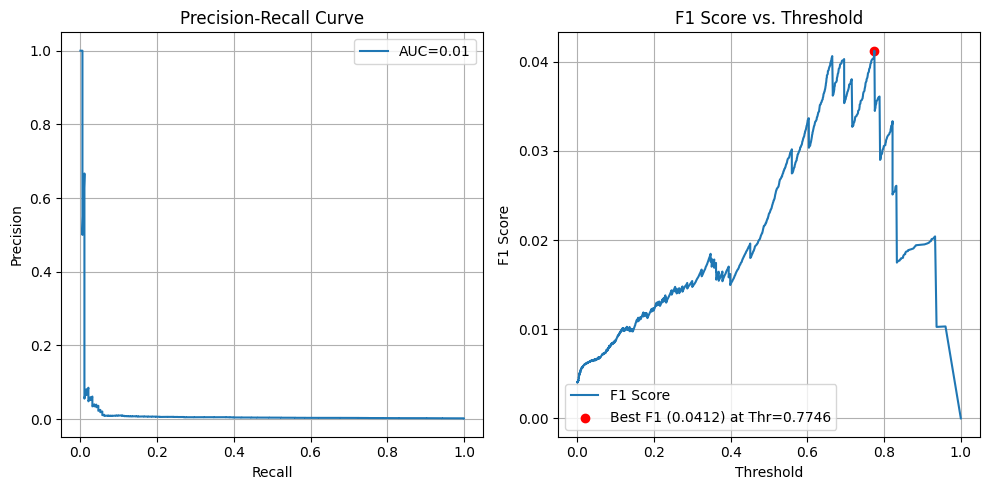


OOF Classification Report (Optimal Threshold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     95469
           1       0.05      0.03      0.03       193

    accuracy                           1.00     95662
   macro avg       0.52      0.51      0.52     95662
weighted avg       1.00      1.00      1.00     95662

OOF Confusion Matrix (Optimal Threshold):
[[95377    92]
 [  188     5]]


In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix, precision_recall_curve, auc
import lightgbm as lgb
import gc # Garbage Collector

# --- Installation Check ---
try:
    from prophet import Prophet
    prophet_installed = True
except ImportError:
    print("Prophet library not found. Please install it: pip install prophet")
    prophet_installed = False

try:
    from hmmlearn import hmm
    hmmlearn_installed = True
except ImportError:
    print("hmmlearn library not found. Please install it: pip install hmmlearn")
    hmmlearn_installed = False

# --- Load Custom Feature Functions (Assuming they are defined above or imported) ---
# Placeholder functions - replace with your actual implementations
def add_global_prophet_features(df, time_col='TransactionStartTime', value_col='Amount'):
    print("--- Running Placeholder: add_global_prophet_features ---")
    # Add dummy columns if Prophet is not installed or fails
    df['prophet_trend'] = 0
    df['prophet_daily'] = 0
    df['prophet_weekly'] = 0
    # Add actual implementation here if installed
    if prophet_installed:
        # PASTE THE UPDATED FUNCTION FROM THE PREVIOUS RESPONSE HERE
        # Make sure it includes the timezone fix and robust checks
        # Example Call (replace with the full function):
        try:
             # --- Ensure time_col is datetime ---
            df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
            if df[time_col].isnull().any():
                print(f"⚠️ Some values in '{time_col}' could not be parsed. Filling NaT.")
                # Decide on fill strategy, e.g., ffill based on sorted data
                df[time_col] = df[time_col].ffill().bfill() # Example fill

            df['date_day'] = df[time_col].dt.normalize() # Get the date part (midnight)

            if df['date_day'].dt.tz is not None:
                print("   Removing timezone information from 'date_day' column.")
                df['date_day'] = df['date_day'].dt.tz_localize(None)

            daily_agg = df.groupby('date_day').agg(y=(value_col, 'sum' if value_col in ['Amount', 'Value'] else 'size')).reset_index().rename(columns={'date_day': 'ds'})

            if len(daily_agg) >= 2:
                data_span_days = (daily_agg['ds'].max() - daily_agg['ds'].min()).days
                use_weekly = data_span_days >= 14
                use_daily = data_span_days >= 2
                model = Prophet(daily_seasonality=use_daily, weekly_seasonality=use_weekly, yearly_seasonality=False)
                model.fit(daily_agg[['ds', 'y']])
                forecast = model.predict(daily_agg[['ds']])
                prophet_features = forecast[['ds', 'trend', 'daily', 'weekly']]
                prophet_features.rename(columns={'trend': 'prophet_trend', 'daily': 'prophet_daily', 'weekly': 'prophet_weekly'}, inplace=True)
                df = pd.merge(df, prophet_features, left_on='date_day', right_on='ds', how='left')
                df.drop(columns=['ds'], inplace=True)
                df['prophet_trend'].fillna(df['prophet_trend'].mean(), inplace=True)
                df['prophet_daily'].fillna(0, inplace=True)
                df['prophet_weekly'].fillna(0, inplace=True)
                print("✅ Prophet features added.")
            else:
                 print("⚠️ Not enough daily data points for Prophet.")
            if 'date_day' in df.columns: df = df.drop(columns=['date_day'])

        except Exception as e:
            print(f"⚠️ Prophet failed: {e}. Using default values.")
            # Ensure columns exist even if it failed
            df['prophet_trend'] = df.get('prophet_trend', 0)
            df['prophet_daily'] = df.get('prophet_daily', 0)
            df['prophet_weekly'] = df.get('prophet_weekly', 0)
    return df


def add_hmm_features(df, user_col='CustomerId', time_col='TransactionStartTime', n_components=3, features_for_hmm=['Amount', 'Value', 'hour']):
    print(f"--- Running Placeholder: add_hmm_features ({'Installed' if hmmlearn_installed else 'Not Installed'}) ---")
    # Add dummy columns
    df['hmm_state'] = -1
    for i in range(n_components): df[f'hmm_prob_state_{i}'] = 0.0
    # Add actual implementation here if installed
    if hmmlearn_installed:
        # PASTE THE HMM FUNCTION HERE
        # Example Call (replace with the full function):
        try:
            print(f"Adding HMM features with {n_components} states...")
            # Assume df is already sorted
            # 1. Calculate time difference
            df['time_since_last_tx'] = df.groupby(user_col)[time_col].diff().dt.total_seconds()
            median_time_diff = df['time_since_last_tx'].median() # Calculate before filling NaNs
            df['time_since_last_tx'].fillna(median_time_diff, inplace=True) # Fill NaNs

            current_features = features_for_hmm + ['time_since_last_tx']
             # Ensure all features exist
            missing_hmm_feats = [f for f in current_features if f not in df.columns]
            if missing_hmm_feats:
                 print(f"⚠️ Missing features required for HMM: {missing_hmm_feats}. Skipping HMM.")
                 return df

            # 2. Select and Scale features
            scaler = StandardScaler()
            hmm_data = df[current_features].copy()
            hmm_data.replace([np.inf, -np.inf], np.nan, inplace=True)
            hmm_data.fillna(0, inplace=True) # Impute NaNs introduced potentially by features/time diff
            scaled_hmm_data = scaler.fit_transform(hmm_data)

            if np.isnan(scaled_hmm_data).any() or np.isinf(scaled_hmm_data).any():
                 print("⚠️ NaN or Inf detected in scaled HMM data. Skipping HMM.")
                 return df

            # 3. Train HMM
            model = hmm.GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=100, random_state=42, tol=0.01)
            model.fit(scaled_hmm_data)

            # 4. Predict states and probabilities
            hidden_states = model.predict(scaled_hmm_data)
            state_probs = model.predict_proba(scaled_hmm_data)

            # 5. Add features
            df['hmm_state'] = hidden_states
            for i in range(n_components): df[f'hmm_prob_state_{i}'] = state_probs[:, i]
            print("✅ HMM features added.")
        except Exception as e:
             print(f"⚠️ HMM failed: {e}. Using default values.")
             df['hmm_state'] = df.get('hmm_state', -1) # Keep existing or set default
             for i in range(n_components): df[f'hmm_prob_state_{i}'] = df.get(f'hmm_prob_state_{i}', 0.0)

    return df


def add_markov_transition_features(df, user_col='CustomerId', time_col='TransactionStartTime', value_col='Amount', n_states=3):
    print(f"--- Running Placeholder: add_markov_transition_features ---")
    # Add dummy columns
    df[f'{value_col}_state'] = -1
    df[f'{value_col}_state_previous'] = -1
    df['markov_transition_prob'] = 0.0
    # Add actual implementation here
    # PASTE THE MARKOV FUNCTION HERE
    # Example Call (replace with the full function):
    try:
        print(f"Adding Markov transition features based on {value_col} with {n_states} states...")
        # Assume df is sorted
        # 1. Define States
        try:
            df[f'{value_col}_state'] = pd.qcut(df[value_col], q=n_states, labels=range(n_states), duplicates='drop').astype(int)
        except ValueError:
            try:
                n_states = 2
                df[f'{value_col}_state'] = pd.qcut(df[value_col], q=n_states, labels=range(n_states), duplicates='drop').astype(int)
                print(f"   Using {n_states} states instead.")
            except ValueError:
                 print("⚠️ Could not create bins. Skipping Markov features.")
                 return df

        # 2. Find previous state
        df[f'{value_col}_state_previous'] = df.groupby(user_col)[f'{value_col}_state'].shift(1).fillna(-1).astype(int)

        # 3. Calculate Global Transition Matrix
        transition_counts = pd.crosstab(df[f'{value_col}_state'], df[f'{value_col}_state_previous'])
        all_states_incl_neg = list(range(n_states))
        all_prev_states_incl_neg = [-1] + list(range(n_states))
        transition_counts = transition_counts.reindex(index=all_states_incl_neg, columns=all_prev_states_incl_neg, fill_value=0)
        transition_probs = transition_counts.div(transition_counts.sum(axis=0) + 1e-9, axis=1)

        # 4. Add transition probability feature
        prob_dict = transition_probs.unstack().to_dict() # Keys: (prev_state, current_state)
        df['markov_transition_prob'] = [prob_dict.get((prev, curr), 0) for prev, curr in zip(df[f'{value_col}_state_previous'], df[f'{value_col}_state'])]
        print("✅ Markov transition features added.")

    except Exception as e:
        print(f"⚠️ Markov features failed: {e}. Using default values.")
        df[f'{value_col}_state'] = df.get(f'{value_col}_state', -1)
        df[f'{value_col}_state_previous'] = df.get(f'{value_col}_state_previous', -1)
        df['markov_transition_prob'] = df.get('markov_transition_prob', 0.0)

    return df


# --- Main Pipeline ---

# 1. Load Data
print("1. Loading data...")
try:
    train_df = pd.read_csv('training.csv')
    test_df = pd.read_csv('test.csv')
    sample_submission = pd.read_csv('sample_submission.csv')
except FileNotFoundError:
    print("ERROR: Make sure training.csv, test.csv, and sample_submission.csv are in the correct directory.")
    exit()

print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")

# 2. Combine & Store Info
print("2. Combining train and test data...")
target = train_df['FraudResult']
train_ids = train_df['TransactionId']
test_ids = test_df['TransactionId']
len_train = len(train_df)

# Drop target from train, align columns (important if test has missing columns)
train_df = train_df.drop(columns=['FraudResult'])
# Align columns before concat, fill missing in test with NaN (to be handled later)
test_df = test_df.reindex(columns=train_df.columns, fill_value=np.nan)
combined_df = pd.concat([train_df, test_df], ignore_index=True)

del train_df, test_df # Conserve memory
gc.collect()

print(f"Combined shape: {combined_df.shape}")

# 3. Initial Feature Engineering (Time)
print("3. Basic time feature engineering...")
time_col = 'TransactionStartTime'
combined_df[time_col] = pd.to_datetime(combined_df[time_col], errors='coerce')
# Handle potential parse errors if any - fill forward/backward after sorting
# combined_df[time_col] = combined_df[time_col].fillna(method='ffill').fillna(method='bfill') # Do this AFTER sorting

combined_df['hour'] = combined_df[time_col].dt.hour
combined_df['dayofweek'] = combined_df[time_col].dt.dayofweek
combined_df['dayofmonth'] = combined_df[time_col].dt.day
combined_df['month'] = combined_df[time_col].dt.month
combined_df['minute'] = combined_df[time_col].dt.minute
combined_df['weekday'] = (combined_df['dayofweek'] < 5).astype(int) # 0=Mon,..., 6=Sun
combined_df['time_epoch'] = combined_df[time_col].astype(np.int64) // 10**9

# --- Choose User Column ---
user_col = 'CustomerId' # Or 'AccountId' - evaluate which works better
print(f"Using '{user_col}' as the user identifier for sequence features.")

# 4. SORT DATA (Crucial Step!)
print(f"4. Sorting data by '{user_col}' and '{time_col}'...")
combined_df = combined_df.sort_values(by=[user_col, time_col])

# Handle any NaT created during time conversion *after* sorting
if combined_df[time_col].isnull().any():
    print(f"   Filling NaT values in '{time_col}' using ffill/bfill...")
    combined_df[time_col] = combined_df[time_col].ffill().bfill()


# 5. Apply Custom Sequential/Temporal Feature Functions
print("5. Applying custom feature engineering functions...")
# --- Prophet Features ---
combined_df = add_global_prophet_features(combined_df, time_col=time_col, value_col='Amount')
gc.collect()

# --- HMM Features ---
# Ensure 'hour' exists from step 3. Add 'Amount', 'Value' if not already features_for_hmm default
hmm_features = ['Amount', 'Value', 'hour'] # Customize as needed
combined_df = add_hmm_features(combined_df, user_col=user_col, time_col=time_col, n_components=3, features_for_hmm=hmm_features)
gc.collect()

# --- Markov Features ---
combined_df = add_markov_transition_features(combined_df, user_col=user_col, time_col=time_col, value_col='Amount', n_states=4) # Example with 4 states
gc.collect()


# 6. Standard Feature Engineering (Aggregations, Categoricals)
print("6. Standard feature engineering (aggregations, encoding)...")
# --- Aggregations ---
# Perform aggregations AFTER sequential features are calculated
numeric_cols = ['Amount', 'Value', 'time_since_last_tx'] # Add HMM/Markov probs? maybe too leaky/complex
categorical_cols = ['ProviderId', 'ProductId', 'ChannelId'] # Add others

for col in [user_col, 'ProviderId', 'ProductId', 'ChannelId']: # IDs to group by
    for agg_func in ['mean', 'std', 'count', 'nunique']: # Aggregation functions
        # Aggregate numeric features
        for num_col in numeric_cols:
             if num_col in combined_df.columns: # Check if col exists (e.g., time_since_last_tx)
                new_col_name = f'{col}_{num_col}_{agg_func}'
                combined_df[new_col_name] = combined_df.groupby(col)[num_col].transform(agg_func)
        # Aggregate categorical features (nunique)
        if agg_func == 'nunique':
            for cat_col in categorical_cols:
                if col != cat_col: # Avoid aggregating a column by itself for nunique
                    new_col_name = f'{col}_{cat_col}_{agg_func}'
                    combined_df[new_col_name] = combined_df.groupby(col)[cat_col].transform('nunique')
    gc.collect()


# --- Categorical Handling (for LightGBM) ---
# Convert object columns (and potential integer categoricals like CountryCode) to 'category' dtype
print("   Converting object/categorical columns to 'category' dtype...")
obj_cols = combined_df.select_dtypes(include='object').columns.tolist()
int_cat_cols = ['CountryCode', 'PricingStrategy'] # Explicitly define integer cols that are categorical

for col in obj_cols + int_cat_cols:
    if col in combined_df.columns and col not in [user_col, 'TransactionId', 'BatchId', time_col]: # Keep user_col if needed later, drop IDs/time
        combined_df[col] = combined_df[col].astype('category')

# Identify all categorical features for LGBM



# 7. Final Preprocessing
print("7. Final preprocessing (dropping cols, splitting back)...")
# --- Drop unnecessary columns ---
cols_to_drop = [
    'TransactionId', 'BatchId', time_col, # Original time column
    user_col, # Drop original user ID if captured by aggregates
    'Amount_state', 'Amount_state_previous', # Markov intermediate columns (or keep state?)
    # Maybe drop high-cardinality IDs if not used or handled:
    'SubscriptionId', 'AccountId', 'CurrencyCode', 'CountryCode','date_day'
]
# Add original numeric cols if log/scaled versions were created and preferred
# Add original categorical cols if frequency/target encoded versions were created

# Ensure columns exist before dropping
cols_to_drop = [col for col in cols_to_drop if col in combined_df.columns]
print(f"   Dropping columns: {cols_to_drop}")
combined_df = combined_df.drop(columns=cols_to_drop)
gc.collect()

categorical_features = combined_df.select_dtypes(include='category').columns.tolist()
print(f"   Identified categorical features for LGBM: {categorical_features}")

# --- Handle Remaining NaNs (from aggregations like std on single counts) ---
# Simple fill with 0, consider more sophisticated imputation if needed
print("   Filling remaining NaNs with 0...")
#combined_df.fillna(0, inplace=True)

# --- Convert infinite values to a large number or NaN (then fill) ---
#combined_df.replace([np.inf, -np.inf], 0, inplace=True) # Replace with 0 or a large number like 99999

# --- Split back into Train and Test ---
train_processed = combined_df.iloc[:len_train]
test_processed = combined_df.iloc[len_train:]
y = target # Use the stored target variable

print(f"Processed Train shape: {train_processed.shape}, Processed Test shape: {test_processed.shape}")
del combined_df; gc.collect()

print(train_processed.info())
# 8. Model Training (LightGBM with CV)
print("8. Training LightGBM model with Stratified K-Fold CV...")
NFOLDS = 5
skf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)

oof_preds = np.zeros(len(train_processed)) # OOF predictions (probabilities)
test_preds = np.zeros(len(test_processed)) # Test set predictions (probabilities)
feature_importances = pd.DataFrame(index=train_processed.columns)

# Calculate scale_pos_weight for imbalance
scale_pos_weight = (y == 0).sum() / (y == 1).sum()
print(f"   Calculated scale_pos_weight: {scale_pos_weight:.2f}")

# LightGBM Parameters (tune these)
params = {
    'objective': 'binary',
    'metric': 'auc', # Optimize for AUC during training, evaluate F1 later
    'boosting_type': 'gbdt',
    'n_estimators': 10000,
    'learning_rate': 0.01,
    'num_leaves': 20, # Lower value to prevent overfitting complex features
    'max_depth': -1,
    'seed': 42,
    'n_jobs': -1,
    'verbose': -1,
    'colsample_bytree': 0.7,
    'subsample': 0.7,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'scale_pos_weight': scale_pos_weight # Handle imbalance
}

for fold, (train_idx, val_idx) in enumerate(skf.split(train_processed, y)):
    print(f"===== Fold {fold+1} / {NFOLDS} =====")
    X_train, y_train = train_processed.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = train_processed.iloc[val_idx], y.iloc[val_idx]

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              eval_metric='auc', # Can use 'f1' if custom eval metric is set up
              callbacks=[lgb.early_stopping(150, verbose=False)], # Increase patience slightly
              categorical_feature=categorical_features) # Pass categorical feature names

    # Predict probabilities
    val_probs = model.predict_proba(X_val)[:, 1]
    test_probs_fold = model.predict_proba(test_processed)[:, 1]

    oof_preds[val_idx] = val_probs
    test_preds += test_probs_fold / NFOLDS

    # Store feature importances
    feature_importances[f'Fold_{fold+1}'] = model.feature_importances_

    print(f"Fold {fold+1} AUC: {model.best_score_['valid_0']['auc']:.4f}")
    del X_train, y_train, X_val, y_val, model; gc.collect()


# 9. Threshold Tuning
print("\n9. Tuning threshold for F1 score on OOF predictions...")
precision, recall, thresholds = precision_recall_curve(y, oof_preds)
# Add threshold for 0 probability if needed, often handled by range
thresholds = np.append(thresholds, 1.0) # Ensure range covers 0 to 1
f1_scores = 2 * recall * precision / (recall + precision + 1e-9)

best_f1_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_f1_idx]
best_f1 = f1_scores[best_f1_idx]

print(f"   Optimal threshold: {best_threshold:.4f}")
print(f"   Best OOF F1-Score: {best_f1:.4f}")

# --- Plot Precision-Recall Curve and F1 ---
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(recall, precision, label=f'AUC={auc(recall, precision):.2f}')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.scatter(best_threshold, best_f1, color='red', label=f'Best F1 ({best_f1:.4f}) at Thr={best_threshold:.4f}')
plt.title('F1 Score vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Evaluate OOF with Optimal Threshold ---
oof_labels = (oof_preds > best_threshold).astype(int)
print("\nOOF Classification Report (Optimal Threshold):")
print(classification_report(y, oof_labels))
print("OOF Confusion Matrix (Optimal Threshold):")
print(confusion_matrix(y, oof_labels))




In [ ]:
model.


10. Predicting on test set using optimal threshold...
11. Generating submission file...

Submission file 'submission.csv' created successfully!
Predicted Fraud distribution in submission:
FraudResult
0    1.0
Name: proportion, dtype: float64


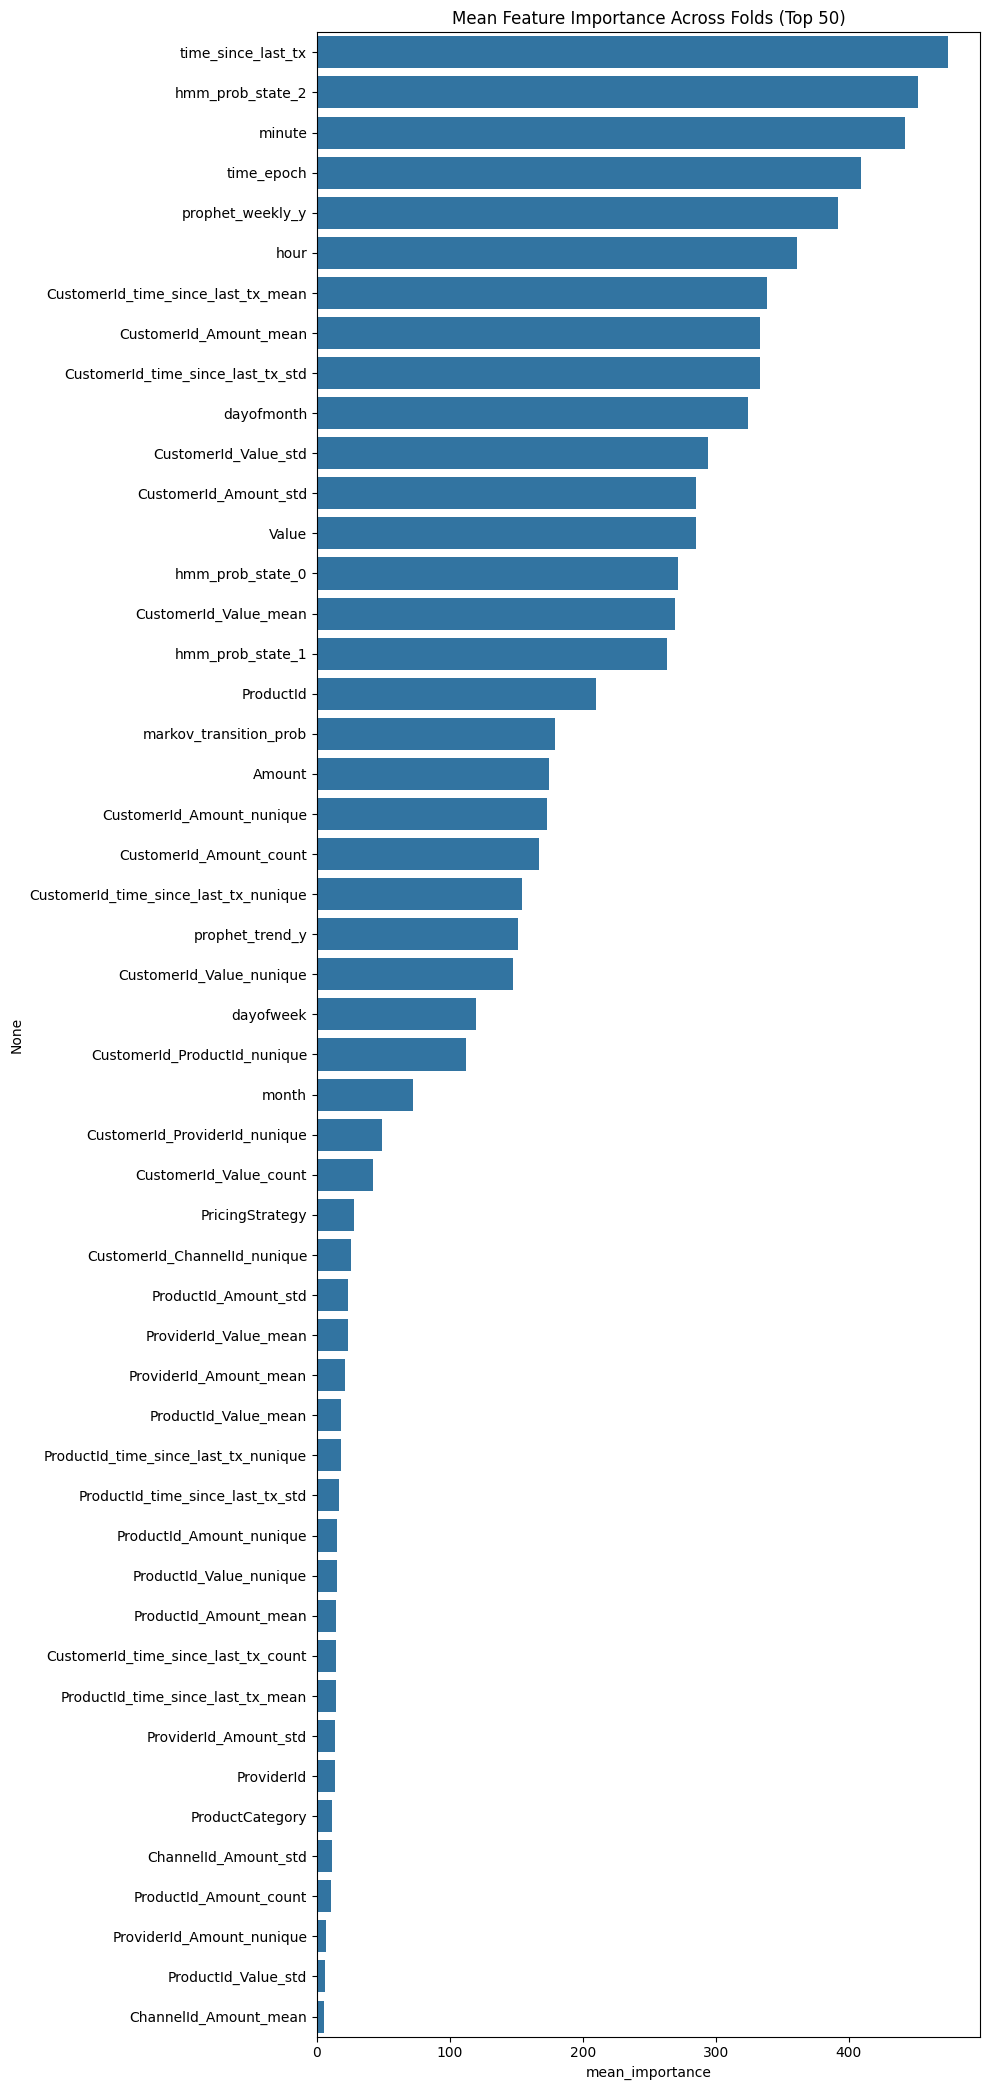


Pipeline finished!


In [283]:
# 10. Prediction on Test Set
print("\n10. Predicting on test set using optimal threshold...")
test_labels = (test_preds > best_threshold).astype(int)


# 11. Generate Submission File
print("11. Generating submission file...")
submission_df = pd.DataFrame({
    'TransactionId': test_ids,
    'FraudResult': test_labels
})
submission_df.to_csv('submission.csv', index=False)

print("\nSubmission file 'submission.csv' created successfully!")
print(f"Predicted Fraud distribution in submission:\n{submission_df['FraudResult'].value_counts(normalize=True)}")

# --- Display Feature Importances ---
feature_importances['mean_importance'] = feature_importances.mean(axis=1)
feature_importances.sort_values(by='mean_importance', ascending=False, inplace=True)

plt.figure(figsize=(10, max(10, len(feature_importances) // 4))) # Adjust height based on number of features
sns.barplot(x='mean_importance', y=feature_importances.index[:50], data=feature_importances.head(50)) # Show top 50
plt.title('Mean Feature Importance Across Folds (Top 50)')
plt.tight_layout()
plt.show()

print("\nPipeline finished!")

In [285]:
submission_df['FraudResult'].value_counts()

FraudResult
0    45019
Name: count, dtype: int64

In [75]:
from sklearn.linear_model import LogisticRegression # Méta-modèle commun
from sklearn.ensemble import StackingClassifier

In [76]:
estimators = [
    ('rf', rfc),    # Le premier élément est un nom, le second l'estimateur
    ('lgbm', lgbm)
]

# Choisir un méta-modèle (simple)
# La régression logistique est souvent un bon choix par défaut
meta_learner = LogisticRegression(solver='liblinear', random_state=42)
# meta_learner = RandomForestClassifier(n_estimators=50, random_state=42) # Alternative

# Définir la stratégie de validation croisée pour entraîner les modèles de base
# sur les données d'entraînement afin de générer les prédictions pour le méta-modèle
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Créer l'ensemble Stacking
# stack_method='predict_proba' -> le méta-modèle utilisera les probabilités des modèles de base
# passthrough=False -> ne passe pas les features originales au méta-modèle (seulement les prédictions)
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_learner,
    cv=cv_strategy, # Important pour générer les prédictions de base correctement
    stack_method='predict_proba',
    n_jobs=-1, # Utiliser tous les cœurs
    passthrough=False
)

# Entraîner l'ensemble Stacking sur les données d'entraînement originales
print("Entraînement du StackingClassifier...")
stacking_clf.fit(X_train, y_train) # Utiliser vos données d'entraînement complètes
print("Entraînement terminé.")



Entraînement du StackingClassifier...
Entraînement terminé.


In [77]:
# Faire les prédictions finales sur l'ensemble de test
print("Prédictions avec le StackingClassifier...")
stacking_predictions = stacking_clf.predict(X_test)
stacking_proba = stacking_clf.predict_proba(X_test)[:, 1] # Si besoin des probas

# Évaluer le modèle Stacking
print("\nMatrice de Confusion (Stacking) :")
print(confusion_matrix(y_test, stacking_predictions))

print("\nScore F1 (Stacking) :")
print(f1_score(y_test, stacking_predictions))

Prédictions avec le StackingClassifier...

Matrice de Confusion (Stacking) :
[[23862     6]
 [   10    38]]

Score F1 (Stacking) :
0.8260869565217391


In [78]:
y_proba_test = stacking_clf.predict_proba(X_test)[:, 1]

# Balayage simple de seuil [0, 1] par pas de 0.01
best_thresh = 0.2
best_f1 = 0

for thresh in np.linspace(0, 1, 101):
    preds_temp = (y_proba_test >= thresh).astype(int)
    f1_temp = f1_score(y_test, preds_temp)
    if f1_temp > best_f1:
        best_f1 = f1_temp
        best_thresh = thresh

print("Meilleur seuil pour le F1:", best_thresh)
print("F1 score avec ce seuil:", best_f1)

Meilleur seuil pour le F1: 0.56
F1 score avec ce seuil: 0.8444444444444444


In [410]:
estimators = [
    ('rf', rfc),    # Le premier élément est un nom, le second l'estimateur
    ('lgbm', lgbm)
]

# Choisir un méta-modèle (simple)
# La régression logistique est souvent un bon choix par défaut
meta_learner = RandomForestClassifier(n_estimators=250,class_weight='balanced', random_state=42)
# meta_learner = RandomForestClassifier(n_estimators=50, random_state=42) # Alternative

# Définir la stratégie de validation croisée pour entraîner les modèles de base
# sur les données d'entraînement afin de générer les prédictions pour le méta-modèle
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Créer l'ensemble Stacking
# stack_method='predict_proba' -> le méta-modèle utilisera les probabilités des modèles de base
# passthrough=False -> ne passe pas les features originales au méta-modèle (seulement les prédictions)
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_learner,
    cv=cv_strategy, # Important pour générer les prédictions de base correctement
    stack_method='predict_proba',
    n_jobs=-1, # Utiliser tous les cœurs
    passthrough=False
)

# Entraîner l'ensemble Stacking sur les données d'entraînement originales
print("Entraînement du StackingClassifier...")
stacking_clf.fit(X_train, y_train) # Utiliser vos données d'entraînement complètes
print("Entraînement terminé.")



Entraînement du StackingClassifier...
Entraînement terminé.


In [411]:
# Faire les prédictions finales sur l'ensemble de test
print("Prédictions avec le StackingClassifier...")
stacking_predictions = stacking_clf.predict(X_test)
stacking_proba = stacking_clf.predict_proba(X_test)[:, 1] # Si besoin des probas

# Évaluer le modèle Stacking
print("\nMatrice de Confusion (Stacking) :")
print(confusion_matrix(y_test, stacking_predictions))

print("\nScore F1 (Stacking) :")
print(f1_score(y_test, stacking_predictions))

Prédictions avec le StackingClassifier...

Matrice de Confusion (Stacking) :
[[28636     5]
 [   13    45]]

Score F1 (Stacking) :
0.8333333333333334


In [412]:
y_proba_test = stacking_clf.predict_proba(X_test)[:, 1]

# Balayage simple de seuil [0, 1] par pas de 0.01
best_thresh = 0.2
best_f1 = 0

for thresh in np.linspace(0, 1, 101):
    preds_temp = (y_proba_test >= thresh).astype(int)
    f1_temp = f1_score(y_test, preds_temp)
    if f1_temp > best_f1:
        best_f1 = f1_temp
        best_thresh = thresh

print("Meilleur seuil pour le F1:", best_thresh)
print("F1 score avec ce seuil:", best_f1)

Meilleur seuil pour le F1: 0.41000000000000003
F1 score avec ce seuil: 0.8468468468468469


In [81]:
test_data_probs = stacking_clf.predict_proba(test_data)
test_data_pred = [1 if y>=0.56 else 0 for y in test_data_probs[:, 1]]

submission = pd.DataFrame({'TransactionId' : testTransId, 'FraudResult' : test_data_pred})
submission.to_csv('submission17_new_first_soluce_stack_tresh_r.csv', index=False)

In [82]:
submission['FraudResult'].value_counts()

FraudResult
0    44948
1       71
Name: count, dtype: int64

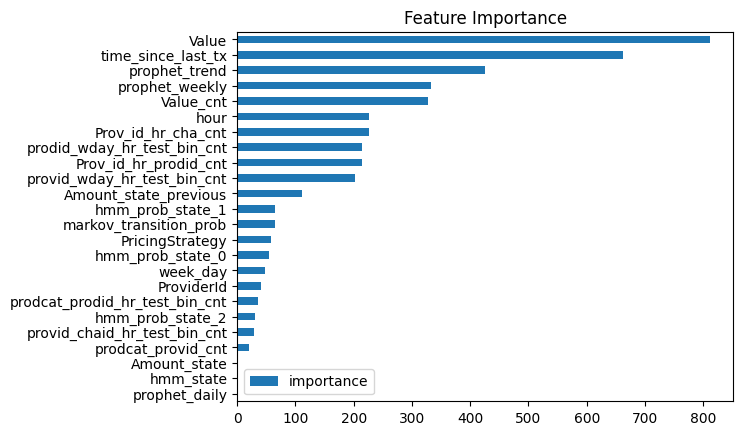

In [200]:
cat_fi = pd.DataFrame(data=lgbm.feature_importances_,
             index=lgbm.feature_name_,
             columns=['importance'])
cat_fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

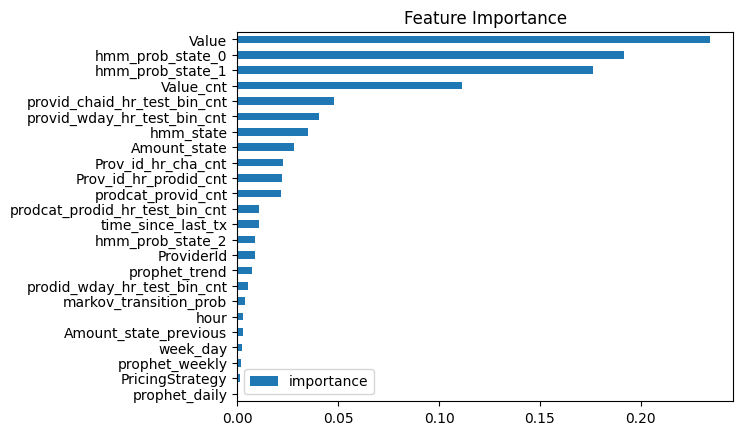

In [201]:
cat_fi = pd.DataFrame(data=rfc.feature_importances_,
             index=rfc.feature_names_in_,
             columns=['importance'])
cat_fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [86]:
from prophet import Prophet
from hmmlearn.hmm import GaussianHMM  # Quand les données parlent en secret et veulent rester discrètes 🤐

In [128]:
import pandas as pd
import numpy as np
from hmmlearn import hmm # Make sure hmmlearn is installed: pip install hmmlearn
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
try:
    from prophet import Prophet
    prophet_installed = True
except ImportError:
    print("Prophet library not found. Please install it: pip install prophet")
    prophet_installed = False

def add_global_prophet_features(df, time_col='TransactionStartTime', value_col='Amount'):
    """
    Adds global trend/seasonality features based on daily transaction volume/amount.
    Ensures the 'ds' column passed to Prophet is timezone-naive.
    """
    if not prophet_installed:
        print("⚠️ Prophet not installed. Skipping Prophet feature generation.")
        df['prophet_trend'] = 0
        df['prophet_daily'] = 0
        df['prophet_weekly'] = 0
        return df

    print(f"Adding Prophet features based on global daily {value_col}...")

    # --- Ensure time_col is datetime ---
    try:
        # Use errors='coerce' to handle potential parsing issues gracefully
        df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
        if df[time_col].isnull().any():
            print(f"⚠️ Some values in '{time_col}' could not be parsed as datetime. These rows might cause issues.")
            # Optional: Handle NaT values, e.g., fill or drop, depending on strategy
            # df = df.dropna(subset=[time_col]) # Example: drop rows with invalid dates
    except Exception as e:
        print(f"⚠️ Error converting '{time_col}' to datetime: {e}. Skipping Prophet features.")
        df['prophet_trend'] = 0
        df['prophet_daily'] = 0
        df['prophet_weekly'] = 0
        return df

    # --- Create date_day and make it timezone-naive ---
    df['date_day'] = df[time_col].dt.normalize() # Get the date part (midnight)

    # <<< --- FIX: Remove Timezone --- >>>
    try:
        # Check if timezone info exists and remove it
        if df['date_day'].dt.tz is not None:
            print("   Removing timezone information from 'date_day' column.")
            df['date_day'] = df['date_day'].dt.tz_localize(None)
        else:
             # If it's already naive, no action needed, but good to know
             # print("   'date_day' column is already timezone-naive.")
             pass
    except AttributeError:
        print(f"⚠️ Could not access '.dt' accessor on 'date_day'. Ensure '{time_col}' conversion worked. Skipping Prophet.")
        df['prophet_trend'] = 0
        df['prophet_daily'] = 0
        df['prophet_weekly'] = 0
        # Clean up column if it exists before returning
        if 'date_day' in df.columns:
             df = df.drop(columns=['date_day'])
        return df
    # <<< --- END FIX --- >>>

    # Aggregate data by day (using the now timezone-naive 'date_day')
    print("   Aggregating data by day...")
    daily_agg = df.groupby('date_day').agg(
        # Use np.sum for Amount/Value, 'size' for count
        y=(value_col, 'sum' if value_col in ['Amount', 'Value'] else 'size')
    ).reset_index().rename(columns={'date_day': 'ds'}) # 'ds' will now be timezone-naive

    if daily_agg.empty or len(daily_agg) < 2:
         print("⚠️ Not enough daily data points to fit Prophet (need at least 2). Skipping.")
         df['prophet_trend'] = 0
         df['prophet_daily'] = 0
         df['prophet_weekly'] = 0
         # Clean up date_day column before returning
         if 'date_day' in df.columns:
              df = df.drop(columns=['date_day'])
         return df

    # Fit Prophet
    # Disable yearly/holidays if data span is short (adjust as needed)
    # Consider data span: If less than 2 weeks, weekly doesn't make sense. If less than 2 days, daily doesn't.
    data_span_days = (daily_agg['ds'].max() - daily_agg['ds'].min()).days
    use_weekly = data_span_days >= 14
    use_daily = data_span_days >= 2

    model = Prophet(daily_seasonality=use_daily, weekly_seasonality=use_weekly, yearly_seasonality=False)
    # Add country-specific holidays if relevant and data spans longer
    # model.add_country_holidays(country_name='UG') # Check correct country code for Xente if needed

    try:
        print(f"   Fitting Prophet (Daily: {use_daily}, Weekly: {use_weekly})...")
        model.fit(daily_agg[['ds', 'y']])

        # Predict on the days we have data for
        print("   Making forecast...")
        forecast = model.predict(daily_agg[['ds']])

        # Select relevant forecast components
        prophet_features = forecast[['ds', 'trend', 'daily', 'weekly']]
        prophet_features.rename(columns={
            'trend': 'prophet_trend',
            'daily': 'prophet_daily',
            'weekly': 'prophet_weekly'
            }, inplace=True)

        # Merge back to the original dataframe
        print("   Merging Prophet features back to main dataframe...")
        # We merge on the timezone-naive 'date_day' column we created earlier
        df = pd.merge(df, prophet_features, left_on='date_day', right_on='ds', how='left')
        df.drop(columns=['ds'], inplace=True) # Drop the 'ds' column from the merge result

        # Fill potential NaNs created by merge (should be minimal, but good practice)
        df['prophet_trend'].fillna(df['prophet_trend'].mean(), inplace=True) # Fill with mean or 0
        df['prophet_daily'].fillna(0, inplace=True) # Seasonality NaNs often best filled with 0
        df['prophet_weekly'].fillna(0, inplace=True)
        print("✅ Prophet features added.")

    except Exception as e:
        print(f"⚠️ Prophet fitting/prediction failed: {e}. Skipping.")
        df['prophet_trend'] = 0
        df['prophet_daily'] = 0
        df['prophet_weekly'] = 0

    # Clean up the temporary date_day column
    if 'date_day' in df.columns:
        df = df.drop(columns=['date_day'])

    return df

In [ ]:
import pandas as pd
import numpy as np
from hmmlearn import hmm # Make sure hmmlearn is installed: pip install hmmlearn
from sklearn.preprocessing import StandardScaler

def add_hmm_features(df, user_col='CustomerId', time_col='TransactionStartTime', n_components=3, features_for_hmm=['Amount', 'Value', 'hour']):
    """
    Adds HMM state and probabilities based on user transaction sequences.
    Assumes df has 'hour' extracted and is sorted by user_col, time_col.
    """
    print(f"Adding HMM features with {n_components} states...")

    # 0. Ensure sorting (Crucial for HMM sequences)
    print("   Sorting data by user and time...")
    df = df.sort_values(by=[user_col, time_col])

    # 1. Calculate time difference (handle first transaction per user)
    print("   Calculating time since last transaction...")
    df['time_since_last_tx'] = df.groupby(user_col)[time_col].diff().dt.total_seconds()
    # Fill NaNs for first transaction, perhaps with a large value or -1, or mean/median
    df['time_since_last_tx'].fillna(df['time_since_last_tx'].median(), inplace=True) # Use median as a placeholder
    features_for_hmm = features_for_hmm + ['time_since_last_tx'] # Add time diff to features

    # 2. Select and Scale features
    print(f"   Scaling features: {features_for_hmm}")
    scaler = StandardScaler()
    hmm_data = df[features_for_hmm].copy()
    # Handle potential infinities or NaNs if any step introduced them
    hmm_data.replace([np.inf, -np.inf], np.nan, inplace=True)
    hmm_data.fillna(0, inplace=True) # Simple imputation, consider more robust methods if needed

    scaled_hmm_data = scaler.fit_transform(hmm_data)

    if np.isnan(scaled_hmm_data).any() or np.isinf(scaled_hmm_data).any():
         print("⚠️ NaN or Inf detected in scaled HMM data after scaling/imputation. Check input features. Skipping HMM.")
         for i in range(n_components):
             df[f'hmm_prob_state_{i}'] = 0.0
         df['hmm_state'] = -1 # Indicate error/skip
         return df


    # 3. Train HMM
    print(f"   Training GaussianHMM with {n_components} states...")
    try:
        model = hmm.GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=100, random_state=42, tol=0.01)
        # Note: Fitting on the whole sequence. For very long data, consider sampling or windowing.
        model.fit(scaled_hmm_data)

        # 4. Predict states and probabilities
        print("   Predicting hidden states and probabilities...")
        hidden_states = model.predict(scaled_hmm_data)
        state_probs = model.predict_proba(scaled_hmm_data)

        # 5. Add features to DataFrame
        df['hmm_state'] = hidden_states
        for i in range(n_components):
            df[f'hmm_prob_state_{i}'] = state_probs[:, i]
        print("✅ HMM features added.")

    except Exception as e:
        print(f"⚠️ HMM fitting/prediction failed: {e}. Skipping.")
        df['hmm_state'] = -1 # Indicate failure
        for i in range(n_components):
            df[f'hmm_prob_state_{i}'] = 0.0

    return df

In [129]:
import pandas as pd
import numpy as np

def add_markov_transition_features(df, user_col='CustomerId', time_col='TransactionStartTime', value_col='Amount', n_states=3):
    """
    Adds Markov transition probability feature based on amount bins.
    Assumes df is sorted by user_col, time_col.
    """
    print(f"Adding Markov transition features based on {value_col} with {n_states} states...")

    # 0. Ensure sorting
    # df = df.sort_values(by=[user_col, time_col]) # Assuming already sorted from HMM step or before

    # 1. Define States (using quantiles of the value_col)
    print("   Defining states using quantiles...")
    try:
        # Use pd.qcut for quantile-based bins. Add include_lowest=True if value_col min is 0.
        df[f'{value_col}_state'] = pd.qcut(df[value_col], q=n_states, labels=range(n_states), duplicates='drop')
        # Convert to integer type after potential float conversion by qcut
        df[f'{value_col}_state'] = df[f'{value_col}_state'].astype(int)
    except ValueError as e:
         print(f"⚠️ Could not create {n_states} distinct quantile bins for {value_col}: {e}. Using 2 bins instead or skipping.")
         try:
             # Try with 2 bins as fallback
             df[f'{value_col}_state'] = pd.qcut(df[value_col], q=2, labels=range(2), duplicates='drop').astype(int)
             n_states = 2
         except ValueError:
             print("⚠️ Still could not create bins. Skipping Markov features.")
             df[f'{value_col}_state_previous'] = -1
             df['markov_transition_prob'] = 0.0
             return df


    # 2. Find previous state for the same user
    print("   Finding previous state per user...")
    df[f'{value_col}_state_previous'] = df.groupby(user_col)[f'{value_col}_state'].shift(1)
    # Handle the first transaction for each user (fill with a special value, e.g., -1 or the state itself)
    df[f'{value_col}_state_previous'].fillna(-1, inplace=True) # Use -1 for "no previous state"
    df[f'{value_col}_state_previous'] = df[f'{value_col}_state_previous'].astype(int)


    # 3. Calculate Global Transition Matrix P(current | previous)
    print("   Calculating global transition matrix...")
    # +1 because states are 0 to n_states-1, and previous can be -1
    transition_counts = pd.crosstab(df[f'{value_col}_state'], df[f'{value_col}_state_previous'])

    # Ensure all possible states (0 to n_states-1 and -1 for previous) are in index/columns
    all_states_incl_neg = list(range(n_states))
    all_prev_states_incl_neg = [-1] + list(range(n_states))
    transition_counts = transition_counts.reindex(index=all_states_incl_neg, columns=all_prev_states_incl_neg, fill_value=0)

    # Normalize counts to get probabilities P(current | previous) = Count(current, previous) / Sum_c(Count(c, previous))
    # Add a small epsilon to avoid division by zero if a previous state never occurs (unlikely with -1)
    transition_probs = transition_counts.div(transition_counts.sum(axis=0) + 1e-9, axis=1)


    # 4. Add transition probability feature to each transaction
    print("   Mapping transition probabilities to transactions...")
    # Create a tuple key for mapping
    df['transition_key'] = list(zip(df[f'{value_col}_state'], df[f'{value_col}_state_previous']))

    # Create a dictionary from the transition probability matrix for faster lookup
    prob_dict = transition_probs.unstack().to_dict() # Creates keys like (prev_state, current_state)

    # Map probabilities - Note: dict keys are (col_idx, row_idx) -> (prev_state, current_state)
    # We need P(current | previous), so we lookup dict[(previous_state, current_state)]
    df['markov_transition_prob'] = df['transition_key'].map(lambda x: prob_dict.get((x[1], x[0]), 0)) # Get prob P(current=x[0] | previous=x[1])


    # Clean up temporary columns
    df.drop(columns=['transition_key'], inplace=True)
    print("✅ Markov transition features added.")

    return df

In [131]:
train_data = pd.read_csv('training.csv', sep=',')
test_data = pd.read_csv('test.csv', sep=',')

In [132]:
train_data['TransactionStartTime'] = pd.to_datetime(train_data['TransactionStartTime'])
test_data['TransactionStartTime'] = pd.to_datetime(test_data['TransactionStartTime'])

In [133]:
train_data['hour'] = train_data['TransactionStartTime'].dt.hour
train_data['week_day'] = train_data['TransactionStartTime'].dt.dayofweek

test_data['hour'] = test_data['TransactionStartTime'].dt.hour
test_data['week_day'] = test_data['TransactionStartTime'].dt.dayofweek

In [134]:
train_data= add_global_prophet_features(train_data)
test_data= add_global_prophet_features(test_data)

Adding Prophet features based on global daily Amount...
   Removing timezone information from 'date_day' column.
   Aggregating data by day...
   Fitting Prophet (Daily: True, Weekly: True)...


18:12:20 - cmdstanpy - INFO - Chain [1] start processing
18:12:22 - cmdstanpy - INFO - Chain [1] done processing


   Making forecast...
   Merging Prophet features back to main dataframe...


C:\Users\HP PRO\AppData\Local\Temp\ipykernel_13500\3643814192.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_features.rename(columns={
C:\Users\HP PRO\AppData\Local\Temp\ipykernel_13500\3643814192.py:119: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['prophet_trend'].fillna(df['prophet_trend'].mean(), inplace=True) # Fill wit

✅ Prophet features added.
Adding Prophet features based on global daily Amount...
   Removing timezone information from 'date_day' column.
   Aggregating data by day...


18:12:23 - cmdstanpy - INFO - Chain [1] start processing


   Fitting Prophet (Daily: True, Weekly: True)...


18:12:23 - cmdstanpy - INFO - Chain [1] done processing


   Making forecast...
   Merging Prophet features back to main dataframe...
✅ Prophet features added.


C:\Users\HP PRO\AppData\Local\Temp\ipykernel_13500\3643814192.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_features.rename(columns={
C:\Users\HP PRO\AppData\Local\Temp\ipykernel_13500\3643814192.py:119: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['prophet_trend'].fillna(df['prophet_trend'].mean(), inplace=True) # Fill wit

In [135]:
train_data = add_hmm_features(train_data)
test_data = add_hmm_features(test_data)

Adding HMM features with 3 states...
   Sorting data by user and time...
   Calculating time since last transaction...
   Scaling features: ['Amount', 'Value', 'hour', 'time_since_last_tx']
   Training GaussianHMM with 3 states...


C:\Users\HP PRO\AppData\Local\Temp\ipykernel_13500\2321042752.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['time_since_last_tx'].fillna(df['time_since_last_tx'].median(), inplace=True) # Use median as a placeholder


   Predicting hidden states and probabilities...
✅ HMM features added.
Adding HMM features with 3 states...
   Sorting data by user and time...
   Calculating time since last transaction...
   Scaling features: ['Amount', 'Value', 'hour', 'time_since_last_tx']
   Training GaussianHMM with 3 states...


C:\Users\HP PRO\AppData\Local\Temp\ipykernel_13500\2321042752.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['time_since_last_tx'].fillna(df['time_since_last_tx'].median(), inplace=True) # Use median as a placeholder


   Predicting hidden states and probabilities...
✅ HMM features added.


In [136]:
train_data = add_markov_transition_features(train_data)
test_data = add_markov_transition_features(test_data)

Adding Markov transition features based on Amount with 3 states...
   Defining states using quantiles...
   Finding previous state per user...
   Calculating global transition matrix...
   Mapping transition probabilities to transactions...


C:\Users\HP PRO\AppData\Local\Temp\ipykernel_13500\4068911859.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[f'{value_col}_state_previous'].fillna(-1, inplace=True) # Use -1 for "no previous state"


✅ Markov transition features added.
Adding Markov transition features based on Amount with 3 states...
   Defining states using quantiles...
   Finding previous state per user...
   Calculating global transition matrix...
   Mapping transition probabilities to transactions...
✅ Markov transition features added.


C:\Users\HP PRO\AppData\Local\Temp\ipykernel_13500\4068911859.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[f'{value_col}_state_previous'].fillna(-1, inplace=True) # Use -1 for "no previous state"


Adding Prophet features based on global daily Amount...
⚠️ Error converting 'TransactionStartTime' to datetime: 'TransactionStartTime'. Skipping Prophet features.


In [99]:
train_data.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'Amount', 'Value',
       'TransactionStartTime', 'PricingStrategy', 'FraudResult', 'hour',
       'week_day', 'time_since_last_tx', 'hmm_state', 'hmm_prob_state_0',
       'hmm_prob_state_1', 'hmm_prob_state_2', 'Amount_state',
       'Amount_state_previous', 'markov_transition_prob', 'prophet_trend',
       'prophet_daily', 'prophet_weekly'],
      dtype='object')

In [271]:
test_data = test_data.drop(['Amount_state','Amount_state_previous', 'markov_transition_prob'], axis=1)

In [291]:
train_data = train_data.drop(['Amount_state','Amount_state_previous', 'markov_transition_prob'], axis=1)

In [405]:
estimators = [
    ('rf', rfc),    # Le premier élément est un nom, le second l'estimateur
    ('lgbm', lgbm)
]

# Choisir un méta-modèle (simple)
# La régression logistique est souvent un bon choix par défaut
meta_learner = lgb.LGBMClassifier(class_weight='balanced',random_state=42)
# meta_learner = RandomForestClassifier(n_estimators=50, random_state=42) # Alternative

# Définir la stratégie de validation croisée pour entraîner les modèles de base
# sur les données d'entraînement afin de générer les prédictions pour le méta-modèle
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Créer l'ensemble Stacking
# stack_method='predict_proba' -> le méta-modèle utilisera les probabilités des modèles de base
# passthrough=False -> ne passe pas les features originales au méta-modèle (seulement les prédictions)
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_learner,
    cv=cv_strategy, # Important pour générer les prédictions de base correctement
    stack_method='predict_proba',
    n_jobs=-1, # Utiliser tous les cœurs
    passthrough=False
)

# Entraîner l'ensemble Stacking sur les données d'entraînement originales
print("Entraînement du StackingClassifier...")
stacking_clf.fit(X_train, y_train) # Utiliser vos données d'entraînement complètes
print("Entraînement terminé.")



Entraînement du StackingClassifier...
Entraînement terminé.


In [406]:
# Faire les prédictions finales sur l'ensemble de test
print("Prédictions avec le StackingClassifier...")
stacking_predictions = stacking_clf.predict(X_test)
stacking_proba = stacking_clf.predict_proba(X_test)[:, 1] # Si besoin des probas

# Évaluer le modèle Stacking
print("\nMatrice de Confusion (Stacking) :")
print(confusion_matrix(y_test, stacking_predictions))

print("\nScore F1 (Stacking) :")
print(f1_score(y_test, stacking_predictions))

Prédictions avec le StackingClassifier...

Matrice de Confusion (Stacking) :
[[28571    70]
 [    7    51]]

Score F1 (Stacking) :
0.5698324022346368


In [ ]:
import catboost as cb

In [139]:
try:
    scale_pos_weight_calc = np.sum(y_train == 0) / np.sum(y_train == 1)
    print(f"Scale_pos_weight calculé (pour info) : {scale_pos_weight_calc:.4f}")
except ZeroDivisionError:
    print("Attention : Division par zéro dans le calcul de scale_pos_weight.")
    scale_pos_weight_calc = 1 # Valeur par défaut

# Note: CatBoost a aussi 'auto_class_weights' que l'on peut tester.

Scale_pos_weight calculé (pour info) : 495.0222


In [306]:
def objective_cb(trial):
    """Fonction objective Optuna pour l'optimisation CatBoost (cible F1)."""

    # --- Définition de l'espace de recherche des hyperparamètres ---
    params = {
        # Fonction de perte standard pour classification binaire
        'loss_function': 'Logloss',
        # Métrique pour l'évaluation interne (early stopping / pruning)
        'eval_metric': 'AUC',
        # Nombre d'itérations élevé, géré par early stopping
        'iterations': trial.suggest_int('iterations', 1000, 5000), # Ou même plus haut si besoin
        # Taux d'apprentissage
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        # Profondeur des arbres
        'depth': trial.suggest_int('depth', 4, 10),
        # Régularisation L2
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        # Nombre de divisions pour les features numériques
        'border_count': trial.suggest_int('border_count', 32, 255),
        # Intensité de la randomisation des divisions
        'random_strength': trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
        # Contrôle pour le bagging (0 = pas de bagging, 1 = bagging fort)
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
         # Poids des classes (alternative à scale_pos_weight)
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', [None, 'Balanced', 'SqrtBalanced']),
        # 'scale_pos_weight': scale_pos_weight_calc, # Ou tester l'optimisation de ce paramètre si 'auto_class_weights' est None

        # Taille max pour l'encodage one-hot des features catégorielles (si utilisées)
        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 16),

        'random_seed': 42,
        'verbose': 0, # Supprimer les logs détaillés de CatBoost pendant l'essai
        # 'task_type': 'GPU' # Décommenter si vous avez un GPU et CatBoost avec support GPU installé
    }

    # Si auto_class_weights est choisi, on ne met pas scale_pos_weight
    if params['auto_class_weights'] is not None:
        # On pourrait aussi l'optimiser si auto_class_weights est None :
        # params['scale_pos_weight'] = trial.suggest_float('scale_pos_weight', 1.0, 100.0) # Exemple de plage
        pass # Ou utiliser la valeur calculée: params['scale_pos_weight'] = scale_pos_weight_calc
    else:
         # Si auto_class_weights est None, utiliser la valeur calculée (ou l'optimiser)
         params['scale_pos_weight'] = scale_pos_weight_calc


    # --- Entraînement du modèle ---
    model = cb.CatBoostClassifier(**params)

    # Définir le callback pour l'élagage Optuna (utilise 'validation-AUC' ou 'learn-AUC' etc.)
    # Le nom de la métrique doit correspondre à ce que CatBoost retourne dans les logs
    # Typiquement 'validation_0-AUC' si eval_set=[(X_val, y_val)]
    # Optuna le gère souvent automatiquement avec l'intégration CatBoost
    pruning_callback = optuna.integration.CatBoostPruningCallback(trial, 'AUC')

    model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)], # Ensemble pour early stopping
              #cat_features=categorical_features_indices, # Important si vous avez des features catégorielles
              early_stopping_rounds=100, # Nombre de tours sans amélioration avant arrêt
              verbose=0, # Pas d'affichage pendant l'entraînement de chaque essai
              callbacks=[pruning_callback] # Intégration de l'élagage Optuna
             )

    # --- Évaluation du modèle avec le score F1 (objectif d'Optuna) ---
    preds_proba = model.predict_proba(X_test)[:, 1]
    threshold = 0.5
    preds_binary = (preds_proba >= threshold).astype(int)
    f1_val_score = f1_score(y_test, preds_binary)

    return f1_val_score # Optuna maximise cette valeur

In [ ]:
study_cb = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10) # Élagage basé sur la médiane
)

# --- Lancement de l'optimisation ---
print("Démarrage de l'optimisation pour CatBoostClassifier...")
study_cb.optimize(objective_cb, n_trials=250, timeout=3600) # Ex: 100 essais ou 1 heure

# --- Affichage des meilleurs résultats ---
print("\nOptimisation CatBoost Terminée !")
print(f"Nombre d'essais terminés : {len(study_cb.trials)}")
print(f"Meilleur essai numéro : {study_cb.best_trial.number}")
# La meilleure valeur rapportée sera le score F1 du meilleur essai
print(f"Meilleur score (F1) : {study_cb.best_value:.6f}")

print("\nMeilleurs hyperparamètres trouvés :")
# Afficher les paramètres optimisés
best_params_cb = study_cb.best_params.copy()
for key, value in best_params_cb.items():
    print(f"  {key}: {value}")


In [310]:
cbf =  cb.CatBoostClassifier(**best_params_cb, verbose=0, scale_pos_weight=scale_pos_weight_calc)

In [311]:
cbf.fit(X_train, y_train)


train_predictions = cbf.predict(X_train)
test_predictions = cbf.predict(X_test)

print('Train Score: {:4f}'.format(f1_score(y_train, train_predictions)))
print('Test Score: {:4f}'.format(f1_score(y_test, test_predictions)))

Train Score: 0.940767
Test Score: 0.779661


In [318]:
cbf.fit(X_train, y_train)


train_predictions = cbf.predict(X_train)
test_predictions = cbf.predict(X_test)

print('Train Score: {:4f}'.format(f1_score(y_train, train_predictions)))
print('Test Score: {:4f}'.format(f1_score(y_test, test_predictions)))

Train Score: 0.940767
Test Score: 0.779661


In [319]:
cross_val_score(cbf, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1, verbose=0).mean()


0.8263838475499092

In [334]:
confusion_matrix(y_test, cbf.predict(X_test))


array([[28627,    14],
       [   12,    46]], dtype=int64)

In [320]:
y_proba_test = cbf.predict_proba(X_test)[:, 1]

# Balayage simple de seuil [0, 1] par pas de 0.01
best_thresh = 0.2
best_f1 = 0

for thresh in np.linspace(0, 1, 101):
    preds_temp = (y_proba_test >= thresh).astype(int)
    f1_temp = f1_score(y_test, preds_temp)
    if f1_temp > best_f1:
        best_f1 = f1_temp
        best_thresh = thresh

print("Meilleur seuil pour le F1:", best_thresh)
print("F1 score avec ce seuil:", best_f1)

Meilleur seuil pour le F1: 0.87
F1 score avec ce seuil: 0.8363636363636363


In [321]:
test_data_probs = cbf.predict_proba(test_data)
test_data_pred = [1 if y>=0.87 else 0 for y in test_data_probs[:, 1]]

submission = pd.DataFrame({'TransactionId' : testTransId, 'FraudResult' : test_data_pred})
submission.to_csv('submission13_first_soluce_catboost_tresh.csv', index=False)

In [322]:
submission['FraudResult'].value_counts()

FraudResult
0    44920
1       99
Name: count, dtype: int64

In [316]:
from catboost import CatBoostError
def objective_cb(trial):
    """Fonction objective Optuna pour l'optimisation CatBoost (cible F1) avec gestion d'erreur interne."""

    # --- Définition de l'espace de recherche (identique) ---
    params = {
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'iterations': trial.suggest_int('iterations', 1000, 5000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 16),
        'random_seed': 42,
        'verbose': 0,
        'scale_pos_weight':scale_pos_weight_calc
    }
   

    # --- Entraînement du modèle ---
    model = cb.CatBoostClassifier(**params)
    pruning_callback = optuna.integration.CatBoostPruningCallback(trial, 'AUC')

    try:
        # --- Bloc try...except autour de fit ---
        model.fit(X_train, y_train,
                  eval_set=[(X_test, y_test)],
                  #cat_features=categorical_features_indices,
                  early_stopping_rounds=100,
                  verbose=0,
                  callbacks=[pruning_callback]
                 )
    except CatBoostError as e:
        # Si une erreur interne CatBoost se produit
        print(f"Essai {trial.number} a échoué à cause d'une CatBoostError: {e}. Élagage de l'essai.")
        # Indiquer à Optuna d'élaguer (ignorer) cet essai
        raise optuna.exceptions.TrialPruned()
    except Exception as e:
         # Gérer d'autres exceptions potentielles si nécessaire
        print(f"Essai {trial.number} a échoué à cause d'une autre exception: {e}. Élagage de l'essai.")
        raise optuna.exceptions.TrialPruned()


    # --- Évaluation (atteint seulement si fit réussit) ---
    preds_proba = model.predict_proba(X_test)[:, 1]
    threshold = 0.5
    preds_binary = (preds_proba >= threshold).astype(int)
    f1_val_score = f1_score(y_test, preds_binary)

    return f1_val_score


In [323]:
def objective_xgb(trial):
    """Fonction objective Optuna pour l'optimisation des hyperparamètres XGBoost (cible F1)."""

    # --- Définition de l'espace de recherche des hyperparamètres ---
    # Utilisation des valeurs initiales comme guide pour les plages
    params = {
        'objective': 'binary:logistic', # Fixe
        'booster': 'gbtree', # Fixe
        'verbosity': 0, # Supprimer les messages détaillés d'XGBoost (0 ou 1)
        # --- Métrique pour l'évaluation interne (early stopping / pruning) ---
        'eval_metric': 'auc', # AUC est stable pour l'évaluation interne
        'random_state': 42, # Reproductibilité
        'n_jobs': -1, # Utiliser tous les cœurs
        # --- Paramètre important pour données déséquilibrées (fixé ici) ---
        'scale_pos_weight': scale_pos_weight_calc, # Utiliser la valeur définie plus haut

        # --- Hyperparamètres à optimiser ---
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0), # Contrôle la complexité
        'subsample': trial.suggest_float('subsample', 0.5, 1.0), # Échantillonnage des lignes
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0), # Échantillonnage des colonnes par arbre
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0), # Échantillonnage des colonnes par niveau
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 1.0, log=True), # Régularisation L1
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 10.0, log=True), # Régularisation L2

        # n_estimators sera géré par l'early stopping, pas besoin de l'optimiser directement
    }

    # --- Entraînement du modèle avec Early Stopping ---
    # n_estimators est mis à une valeur élevée, l'early stopping trouvera le meilleur nombre
    model = xgb.XGBClassifier(**params, n_estimators=3000, use_label_encoder=False)

    # Définir le callback pour l'élagage Optuna
    # La clé d'observation correspond au nom dans eval_set ('validation_0') et à l'eval_metric ('auc')
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, 'validation_0-auc')

    model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)], # Ensemble pour l'early stopping
              #early_stopping_rounds=100, # Arrêter si l'AUC sur eval_set ne s'améliore pas pendant 100 tours
              verbose=False, # Pas d'affichage pendant l'entraînement de chaque essai
              #callbacks=[pruning_callback] # Intégration de l'élagage Optuna
             )

    # --- Évaluation du modèle avec le score F1 (objectif d'Optuna) ---
    # Prédiction des probabilités
    preds_proba = model.predict_proba(X_test)[:, 1]

    # Conversion en prédictions binaires (seuil standard 0.5)
    # Pour maximiser F1, l'ajustement du seuil *après* l'optimisation peut être bénéfique
    threshold = 0.5
    preds_binary = (preds_proba >= threshold).astype(int)

    # Calcul du score F1
    # C'est ce score qu'Optuna va chercher à maximiser
    f1_val_score = f1_score(y_test, preds_binary)

    # --- Retourner le score F1 ---
    return f1_val_score # Optuna maximise cette valeur

In [ ]:
# --- Création de l'étude ---
# direction='maximize' car on veut maximiser le score F1
study_xgb = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42), # Sampler standard efficace
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10) # Élagage basé sur la médiane
)

# --- Lancement de l'optimisation ---
# n_trials: Nombre de combinaisons d'hyperparamètres à tester
# timeout: Limite de temps optionnelle en secondes
study_xgb.optimize(objective_xgb, n_trials=300, timeout=3600) # Ex: 100 essais ou 1 heure

# --- Affichage des meilleurs résultats ---
print("\nOptimisation XGBoost Terminée !")
print(f"Nombre d'essais terminés : {len(study_xgb.trials)}")
print(f"Meilleur essai numéro : {study_xgb.best_trial.number}")
# La meilleure valeur rapportée sera le score F1 du meilleur essai
print(f"Meilleur score (F1) : {study_xgb.best_value:.6f}")

print("\nMeilleurs hyperparamètres trouvés :")
for key, value in study_xgb.best_params.items():
    print(f"  {key}: {value}")

# --- Optionnel : Entraînement du modèle final avec les meilleurs paramètres ---
print("\nEntraînement du modèle final XGBoost avec les meilleurs paramètres sur toutes les données d'entraînement...")

best_params_xgb = study_xgb.best_params.copy()
best_params_xgb

In [327]:
xgbm =  xgb.XGBClassifier(**best_params_xgb, n_estimators=3000, use_label_encoder=False, 
                         objective='binary:logistic', # Fixe
        booster='gbtree', # Fixe
        verbosity= 0, # Supprimer les messages détaillés d'XGBoost (0 ou 1)
        # --- Métrique pour l'évaluation interne (early stopping / pruning) ---
        eval_metric= 'auc', # AUC est stable pour l'évaluation interne
        random_state= 42, # Reproductibilité
        n_jobs= -1, # Utiliser tous les cœurs
        # --- Paramètre important pour données déséquilibrées (fixé ici) ---
        scale_pos_weight= scale_pos_weight_calc,)

In [328]:
xgbm.fit(X_train, y_train)


train_predictions = xgbm.predict(X_train)
test_predictions = xgbm.predict(X_test)

print('Train Score: {:4f}'.format(f1_score(y_train, train_predictions)))
print('Test Score: {:4f}'.format(f1_score(y_test, test_predictions)))

Train Score: 0.909091
Test Score: 0.721311


In [335]:
confusion_matrix(y_test, xgbm.predict(X_test))


array([[28621,    20],
       [   14,    44]], dtype=int64)

In [329]:
cross_val_score(xgbm, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1, verbose=0)


array([0.71875   , 0.78688525, 0.75862069, 0.64705882, 0.70967742])

In [330]:
y_proba_test = xgbm.predict_proba(X_test)[:, 1]

# Balayage simple de seuil [0, 1] par pas de 0.01
best_thresh = 0.2
best_f1 = 0

for thresh in np.linspace(0, 1, 101):
    preds_temp = (y_proba_test >= thresh).astype(int)
    f1_temp = f1_score(y_test, preds_temp)
    if f1_temp > best_f1:
        best_f1 = f1_temp
        best_thresh = thresh

print("Meilleur seuil pour le F1:", best_thresh)
print("F1 score avec ce seuil:", best_f1)

Meilleur seuil pour le F1: 0.49
F1 score avec ce seuil: 0.7213114754098361


In [187]:
def get_models():
    """Generate a library of base learners."""

    models = {'lgb': lgbm,
              
              }

    return models

In [188]:

base_learners = get_models()
meta_learner = rfc

In [194]:
from sklearn.metrics import f1_score
from mlens.ensemble import SuperLearner

In [193]:
pip install --upgrade mlens

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [196]:
from sklearn.ensemble import StackingClassifier

# Assurez-vous que base_learners est une liste de tuples (nom, estimateur)
estimators = list(base_learners.items())

# Exemple de meta-learner (doit être un classifieur)
meta_learner_sklearn = rfc # ou RandomForestClassifier(), etc.

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_learner_sklearn,
    cv=5, # Nombre de folds pour entraîner les modèles de base
    stack_method='predict_proba', # Si les modèles de base retournent des probas
    n_jobs=-1,
    passthrough=False # Ne pas passer les features originales au meta-learner
)

# Entraîner l'ensemble
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lgb',
                                LGBMClassifier(colsample_bytree=0.5270470489419843,
                                               learning_rate=0.09857986129492063,
                                               max_depth=11,
                                               min_child_samples=41,
                                               min_child_weight=0.3071823303679761,
                                               min_split_gain=0.34319608956703834,
                                               num_leaves=14,
                                               reg_alpha=0.0004083968741705973,
                                               reg_lambda=0.0045282332810723715,
                                               subsample=0.6109954111187308,
                                               subsample_for_bin=100000,
                                               subsample_freq=10))],
                   final_estimator=RandomForestClassifier(criterion='entropy',
                                                          max_depth=12),
                   n_jobs=-1, stack_method='predict_proba')

In [199]:
p_sl = stacking_clf.predict_proba(X_test)
pred = [1 if y>=0.5 else 0 for y in p_sl[:, 1]]

print(f"Super Learner f1 score: {f1_score(y_test, pred)}")

Super Learner f1 score: 0.819672131147541


In [204]:
cross_val_score(stacking_clf, X, y, scoring='f1', cv=5, n_jobs=-1)

array([0.91891892, 0.71794872, 0.44      , 0.44776119, 0.70103093])

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, p_sl[:,1])


In [200]:
precision, recall, thresholds = precision_recall_curve(y_test, p_sl[:,1])


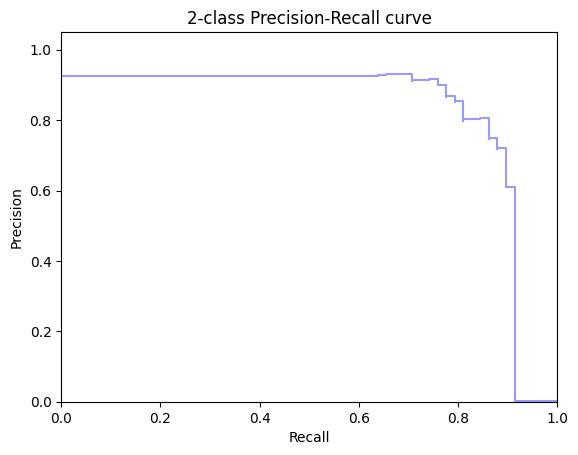

In [201]:
thresholds = np.append(thresholds, 1)
f1_scores = 2*(precision*recall)/(precision+recall)
plt.step(recall, precision, color='b', alpha=0.4, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')
plt.show()

Threshold cutoff:  0.5433137254901961
Max F1-score at cut-off :  0.8333333333333334


<Axes: xlabel='thresholds'>

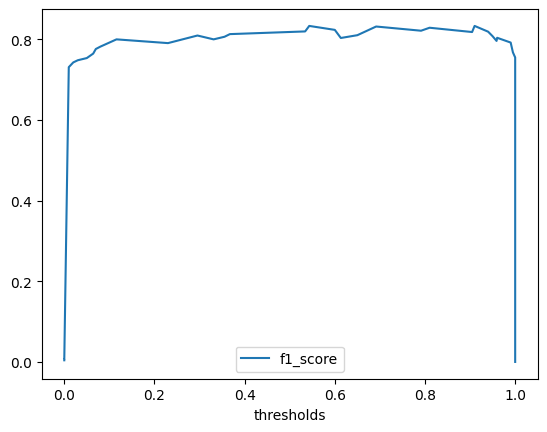

In [205]:
scrs = pd.DataFrame({'precision' : precision, 'recal' : recall, 'thresholds' : thresholds, 'f1_score':f1_scores})
print("Threshold cutoff: ",scrs.loc[scrs['f1_score'] == scrs.f1_score.max(),'thresholds'].iloc[0])
print("Max F1-score at cut-off : ",scrs.f1_score.max())

thresh = scrs.loc[scrs['f1_score'] == scrs.f1_score.max(),'thresholds'].iloc[0]

scrs.plot(x='thresholds', y='f1_score')

In [206]:
scrs.loc[scrs['f1_score'] == scrs.f1_score.max()]


,precision,recal,thresholds,f1_score
23,0.806452,0.862069,0.543314,0.833333
31,0.900000,0.775862,0.910000,0.833333


In [208]:
frame = scrs.loc[scrs['precision'] == scrs['recal']]
thresh = frame['thresholds'].values[0]
thresh

0.65

In [210]:
pred = [1 if y>=0.5433137254901961 else 0 for y in p_sl[:, 1]]

f1_score(y_test, pred)

0.8333333333333334

In [213]:
test_data_probs = stacking_clf.predict_proba(test_data)
test_data_pred = [1 if y>=0.5 else 0 for y in test_data_probs[:, 1]]

submission = pd.DataFrame({'TransactionId' : testTransId, 'FraudResult' : test_data_pred})
submission.to_csv('submission12_stacking_lgbm_rfc_no_tresh.csv', index=False)

In [214]:
submission['FraudResult'].value_counts()

FraudResult
0    44926
1       93
Name: count, dtype: int64

In [215]:
most_freq_hours = [17, 16, 9, 13, 18]
least_freq_hours = [0, 1, 23, 2, 3, 22]

In [216]:
X_train.columns

Index(['ProviderId_ProviderId_2', 'ProviderId_ProviderId_3',
       'ProviderId_ProviderId_4', 'ProviderId_ProviderId_5',
       'ProviderId_ProviderId_6', 'ProductCategory_data_bundles',
       'ProductCategory_financial_services', 'ProductCategory_movies',
       'ProductCategory_other', 'ProductCategory_retail',
       'ProductCategory_ticket', 'ProductCategory_transport',
       'ProductCategory_tv', 'ProductCategory_utility_bill',
       'ChannelId_ChannelId_2', 'ChannelId_ChannelId_3',
       'ChannelId_ChannelId_4', 'ChannelId_ChannelId_5', 'PricingStrategy_1',
       'PricingStrategy_2', 'PricingStrategy_4', 'Year_2019', 'Month_February',
       'Month_January', 'Month_March', 'Month_November', 'Weekday_Monday',
       'Weekday_Saturday', 'Weekday_Sunday', 'Weekday_Thursday',
       'Weekday_Tuesday', 'Weekday_Wednesday', 'Time Interval_early morning',
       'Time Interval_evening', 'Time Interval_morning', 'Time Interval_night',
       'Amount', 'ExtraCharges'],
      dtype='

In [217]:
df['hour'] = df['TransactionStartTime'].dt.hour

NameError: name 'df' is not defined